# Airline Customer Value Analysis - Clustering K-Means Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D

from dateutil import relativedelta
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score

In [2]:
sns.set(rc={'figure.figsize':(20.7, 8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Data Collection

In [3]:
data = pd.read_csv('data/flight.csv')
data

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE  GENDER  FFP_TIER    WORK_CITY  \
0          54993  11/2/2006        12/24/2008    Male         6            .   
1          28065  2/19/2007          8/3/2007    Male         6          NaN   
2          55106   2/1/2007         8/30/2007    Male         6            .   
3          21189  8/22/2008         8/23/2008    Male         5  Los Angeles   
4          39546  4/10/2009         4/15/2009    Male         6      guiyang   
...          ...        ...               ...     ...       ...          ...   
62983      18375  5/20/2011          6/5/2013  Female         4    guangzhou   
62984      36041   3/8/2010         9/14/2013    Male         4       foshan   
62985      45690  3/30/2006         12/2/2006  Female         4    guangzhou   
62986      61027   2/6/2013         2/14/2013  Female         4    guangzhou   
62987      61340  2/17/2013         2/17/2013  Female         4     shanghai   

      WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  SUM_YR_2  SEG_KM_SUM  \
0           beijing           CN  31.0  3/31/2014  ...  234188.0      580717   
1           beijing           CN  42.0  3/31/2014  ...  167434.0      293678   
2           beijing           CN  40.0  3/31/2014  ...  164982.0      283712   
3                CA           US  64.0  3/31/2014  ...  125500.0      281336   
4           guizhou           CN  48.0  3/31/2014  ...  130702.0      309928   
...             ...          ...   ...        ...  ...       ...         ...   
62983     guangdong           CN  25.0  3/31/2014  ...       0.0        1134   
62984     guangdong           CN  38.0  3/31/2014  ...       0.0        8016   
62985     guangdong           CN  43.0  3/31/2014  ...       0.0        2594   
62986     guangdong           CN  36.0  3/31/2014  ...       0.0        3934   
62987             .           CN  29.0  3/31/2014  ...       0.0        4222   

       LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL MAX_INTERVAL  \
0             3/31/2014            1      3.483254           18   
1             3/25/2014            7      5.194245           17   
2             3/21/2014           11      5.298507           18   
3            12/26/2013           97     27.863636           73   
4             3/27/2014            5      4.788079           47   
...                 ...          ...           ...          ...   
62983          6/9/2013          297      4.000000            4   
62984          1/3/2014           89     37.000000           60   
62985          3/3/2014           29    166.000000          166   
62986         2/26/2013          400     12.000000           12   
62987         2/23/2013          403      6.000000            6   

       EXCHANGE_COUNT  avg_discount  Points_Sum  Point_NotFlight  
0                  34      0.961639      619760               50  
1                  29      1.252314      415768               33  
2                  20      1.254676      406361               26  
3                  11      1.090870      372204               12  
4                  27      0.970658      338813               39  
...               ...           ...         ...              ...  
62983               1      0.000000       12318               22  
62984              14      0.000000      106972               43  
62985               0      0.000000           0                0  
62986               0      0.000000           0                0  
62987               0      0.000000           0                0  

[62988 rows x 23 columns]

# Data Understanding

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [5]:
pd.options.display.max_colwidth = 100

description = pd.read_excel('data/description.xlsx')
description

description.style.set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])

## EDA

In [6]:
data_copy = data.copy()

### Numerical

In [7]:
data_copy.select_dtypes(include = np.number).columns

Index(['MEMBER_NO', 'FFP_TIER', 'AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1',
       'SUM_YR_2', 'SEG_KM_SUM', 'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL',
       'EXCHANGE_COUNT', 'avg_discount', 'Points_Sum', 'Point_NotFlight'],
      dtype='object')

In [8]:
# exclude 'MEMBER_NO'
features_num = [
    'FFP_TIER', 'AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1',
    'SUM_YR_2', 'SEG_KM_SUM', 'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL',
    'EXCHANGE_COUNT', 'avg_discount', 'Points_Sum', 'Point_NotFlight'
]
len(features_num)

14

Describe all numerical features except 'MEMBER_NO'.

In [9]:
data_copy[features_num].describe().T

count          mean           std    min          25%  \
FFP_TIER         62988.0      4.102162      0.373856    4.0     4.000000   
AGE              62568.0     42.476346      9.885915    6.0    35.000000   
FLIGHT_COUNT     62988.0     11.839414     14.049471    2.0     3.000000   
BP_SUM           62988.0  10925.081254  16339.486151    0.0  2518.000000   
SUM_YR_1         62437.0   5355.376064   8109.450147    0.0  1003.000000   
SUM_YR_2         62850.0   5604.026014   8703.364247    0.0   780.000000   
SEG_KM_SUM       62988.0  17123.878691  20960.844623  368.0  4747.000000   
LAST_TO_END      62988.0    176.120102    183.822223    1.0    29.000000   
AVG_INTERVAL     62988.0     67.749788     77.517866    0.0    23.370370   
MAX_INTERVAL     62988.0    166.033895    123.397180    0.0    79.000000   
EXCHANGE_COUNT   62988.0      0.319775      1.136004    0.0     0.000000   
avg_discount     62988.0      0.721558      0.185427    0.0     0.611997   
Points_Sum       62988.0  12545.777100  20507.816700    0.0  2775.000000   
Point_NotFlight  62988.0      2.728155      7.364164    0.0     0.000000   

                         50%           75%       max  
FFP_TIER            4.000000      4.000000       6.0  
AGE                41.000000     48.000000     110.0  
FLIGHT_COUNT        7.000000     15.000000     213.0  
BP_SUM           5700.000000  12831.000000  505308.0  
SUM_YR_1         2800.000000   6574.000000  239560.0  
SUM_YR_2         2773.000000   6845.750000  234188.0  
SEG_KM_SUM       9994.000000  21271.250000  580717.0  
LAST_TO_END       108.000000    268.000000     731.0  
AVG_INTERVAL       44.666667     82.000000     728.0  
MAX_INTERVAL      143.000000    228.000000     728.0  
EXCHANGE_COUNT      0.000000      0.000000      46.0  
avg_discount        0.711856      0.809476       1.5  
Points_Sum       6328.500000  14302.500000  985572.0  
Point_NotFlight     0.000000      1.000000     140.0

In [10]:
data_copy[features_num].skew()

FFP_TIER           3.873291
AGE                0.625951
FLIGHT_COUNT       3.215305
BP_SUM             5.660473
SUM_YR_1           5.088035
SUM_YR_2           4.601346
SEG_KM_SUM         3.884612
LAST_TO_END        1.178071
AVG_INTERVAL       3.207375
MAX_INTERVAL       1.073333
EXCHANGE_COUNT     8.199608
avg_discount       0.956793
Points_Sum         8.383897
Point_NotFlight    4.270492
dtype: float64

- Skewness essentially measures the symmetry of the distribution.
- All numerical features are skewed because skewness is **more than 0.5**

#### PLOT Numerical 

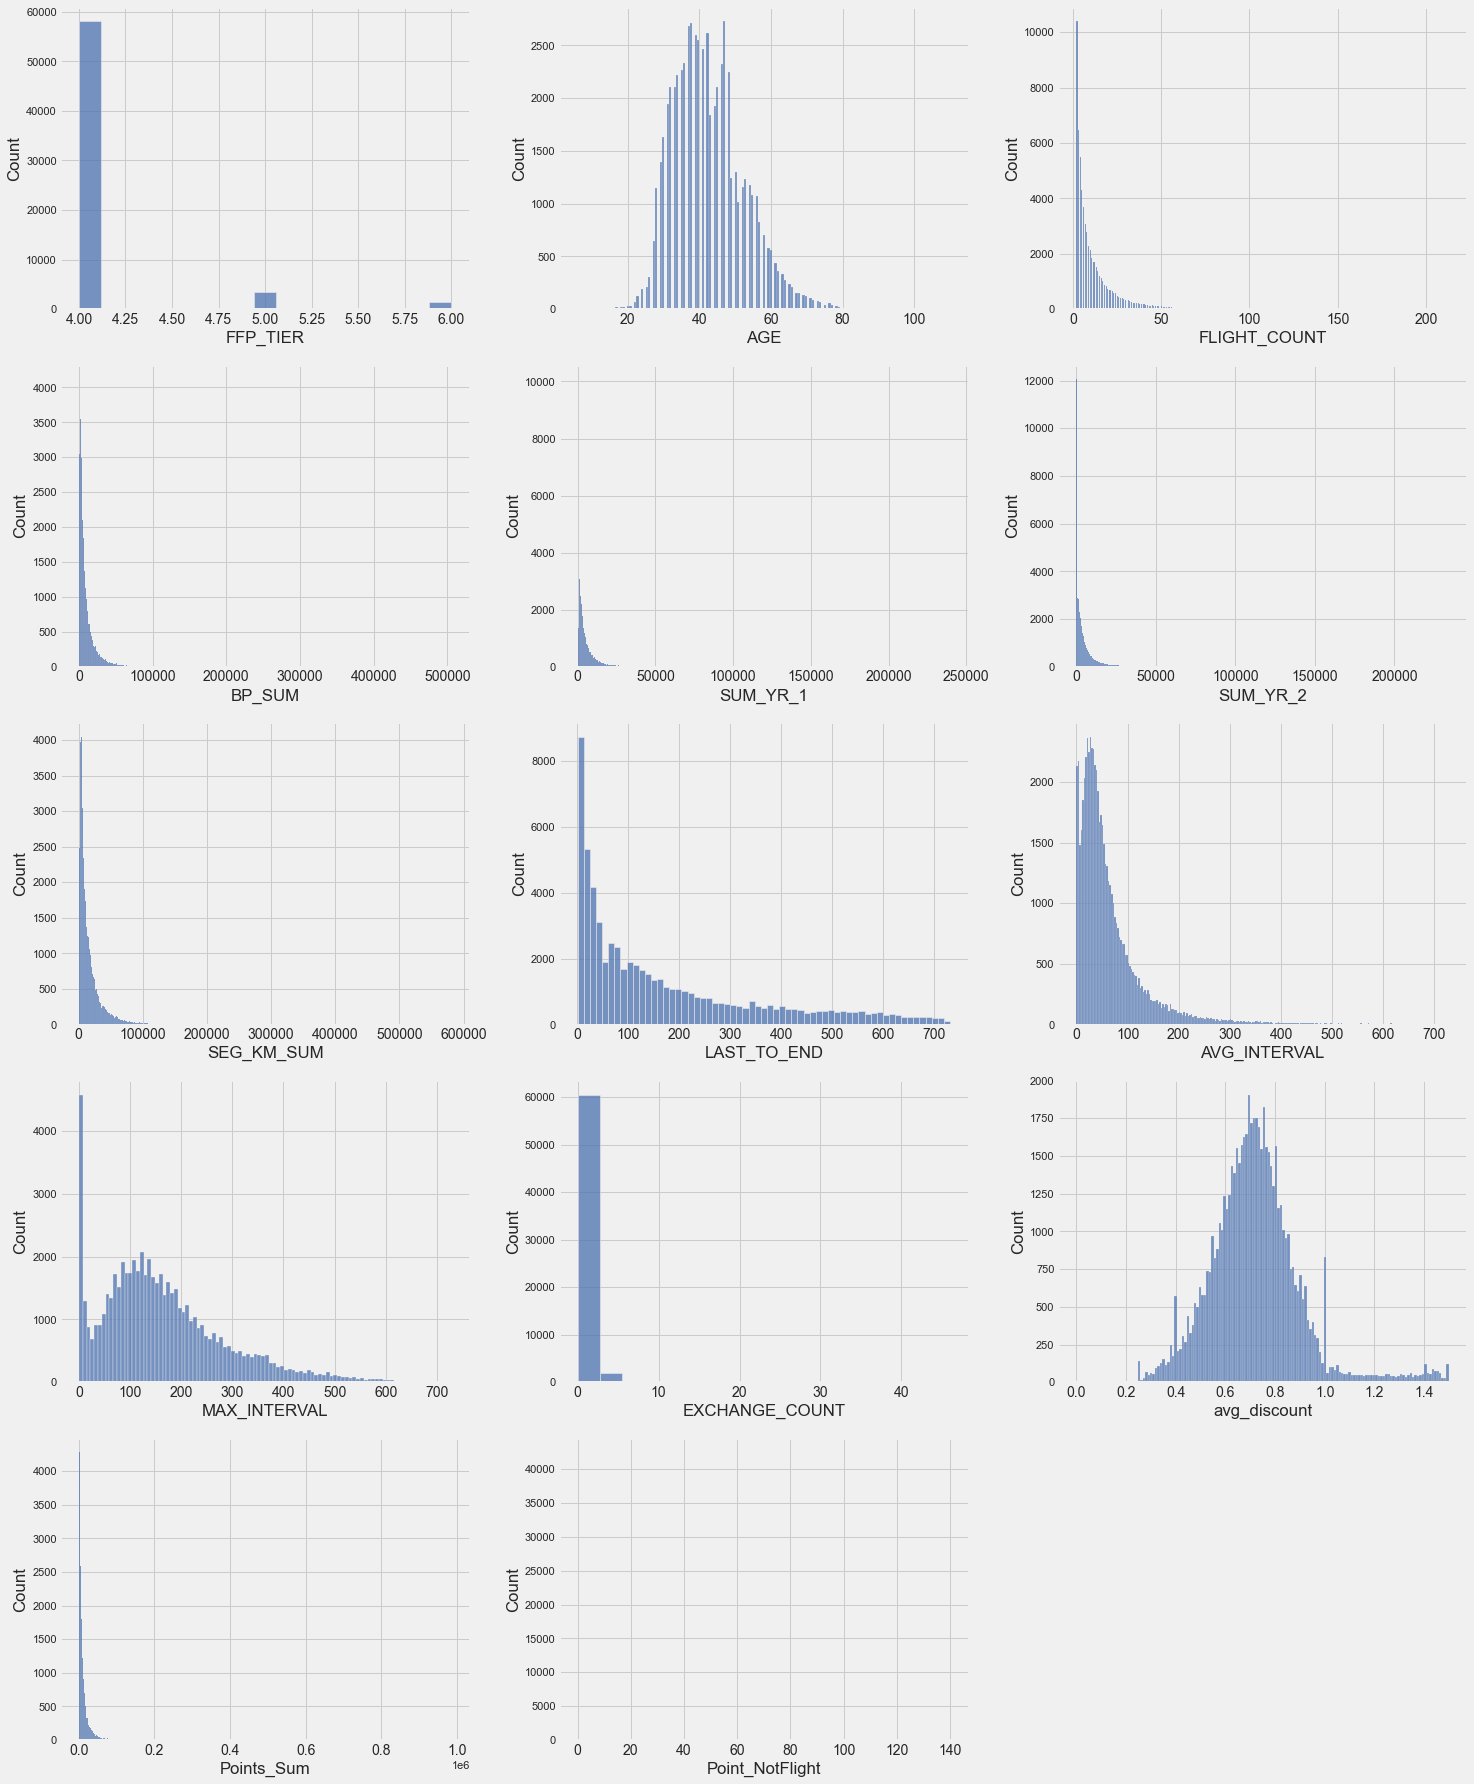

In [11]:
plt.figure(figsize = (20.7, 25))

for i in range(0, len(features_num)):
    plt.subplot(5, 3, i + 1)
    sns.histplot(
        x = features_num[i],
        data = data_copy
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/EDA/numerical histplot.png', bbox_inches = 'tight')

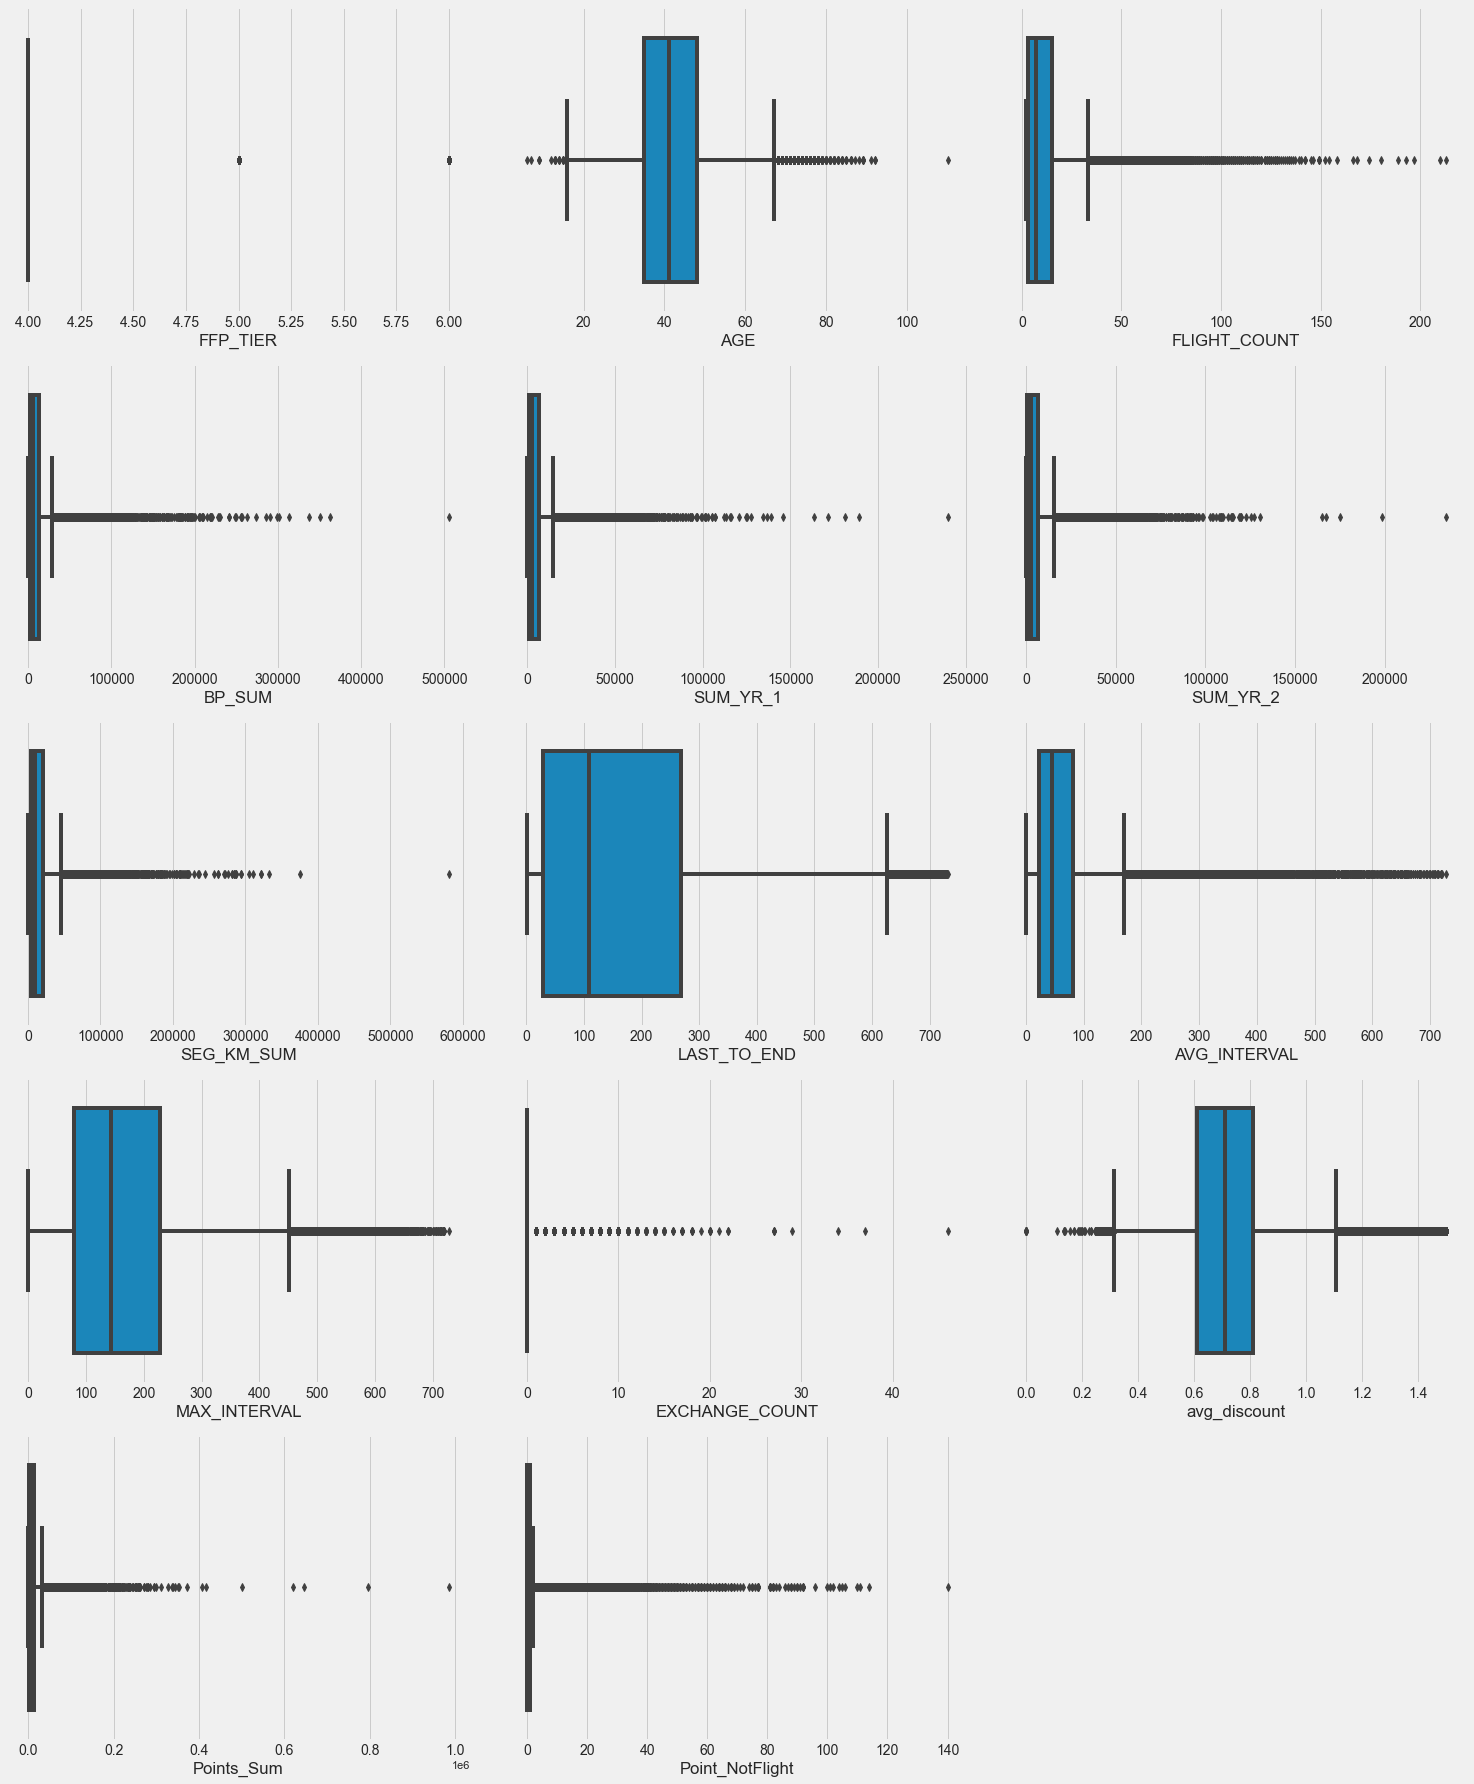

In [12]:
plt.figure(figsize = (20.7, 25))

for i in range(0, len(features_num)):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(
        x = features_num[i],
        data = data_copy
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/EDA/numerical boxplot.png', bbox_inches = 'tight')

### Categorical

In [13]:
data_copy.select_dtypes(include = object).columns

Index(['FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'WORK_CITY', 'WORK_PROVINCE',
       'WORK_COUNTRY', 'LOAD_TIME', 'LAST_FLIGHT_DATE'],
      dtype='object')

In [14]:
features_cat = [
    'FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'WORK_CITY', 'WORK_PROVINCE',
    'WORK_COUNTRY', 'LOAD_TIME', 'LAST_FLIGHT_DATE'
]
len(features_cat)

8

In [15]:
data_copy[features_cat].describe().T

count unique        top   freq
FFP_DATE           62988   3068  1/13/2011    184
FIRST_FLIGHT_DATE  62988   3406  2/16/2013     96
GENDER             62985      2       Male  48134
WORK_CITY          60719   3234  guangzhou   9386
WORK_PROVINCE      59740   1165  guangdong  17509
WORK_COUNTRY       62962    118         CN  57748
LOAD_TIME          62988      1  3/31/2014  62988
LAST_FLIGHT_DATE   62988    731  3/31/2014    959

- Columns which values are date will be extracted in pre-processing.
- Columns that have a lot of unique values will be grouped (top 5 or 10 based on quantity).

- Columns that contain string values are inconsistent, some of them are written in UPPERCASE/LOWERCASE, therefore to check the exact number of unique values, we need to convert them to the same form.

#### WORK_CITY

In [16]:
data_copy['WORK_CITY'].describe().T

count         60719
unique         3234
top       guangzhou
freq           9386
Name: WORK_CITY, dtype: object

In [17]:
data_copy['WORK_CITY'].str.lower().describe().T

count         60719
unique         3068
top       guangzhou
freq           9393
Name: WORK_CITY, dtype: object

In [18]:
print(3234 - 3068, 'values are not unique, they were just written in different form.')

data_copy['WORK_CITY'] = data_copy['WORK_CITY'].str.lower()

166 values are not unique, they were just written in different form.


In [19]:
data_copy['WORK_CITY'].describe().T

count         60719
unique         3068
top       guangzhou
freq           9393
Name: WORK_CITY, dtype: object

#### WORK_PROVINCE

In [20]:
data_copy['WORK_PROVINCE'].describe().T

count         59740
unique         1165
top       guangdong
freq          17509
Name: WORK_PROVINCE, dtype: object

In [21]:
data_copy['WORK_PROVINCE'].str.lower().describe().T

count         59740
unique         1045
top       guangdong
freq          17519
Name: WORK_PROVINCE, dtype: object

In [22]:
print(1165 - 1045, 'values are not unique, they were just written in different form.')

data_copy['WORK_PROVINCE'] = data_copy['WORK_PROVINCE'].str.lower()

120 values are not unique, they were just written in different form.


In [23]:
data_copy['WORK_PROVINCE'].describe().T

count         59740
unique         1045
top       guangdong
freq          17519
Name: WORK_PROVINCE, dtype: object

#### WORK_COUNTRY

In [24]:
data_copy['WORK_COUNTRY'].describe().T

count     62962
unique      118
top          CN
freq      57748
Name: WORK_COUNTRY, dtype: object

In [25]:
data_copy['WORK_COUNTRY'].str.upper().describe().T

count     62962
unique      117
top          CN
freq      57749
Name: WORK_COUNTRY, dtype: object

In [26]:
print(118 - 117, 'values are not unique, they were just written in different format.')

data_copy['WORK_COUNTRY'] = data_copy['WORK_COUNTRY'].str.upper()

1 values are not unique, they were just written in different format.


In [27]:
data_copy['WORK_COUNTRY'].describe().T

count     62962
unique      117
top          CN
freq      57749
Name: WORK_COUNTRY, dtype: object

#### Categorical Features in Date

- We can not see clearly the distribution since there are too many unique values. One of the solutions is to group them based on month-year.
- 'LOAD_TIME' feature only has one unique value, therefore no need to check the distribution.

- 'FIRST_FLIGHT_YEARS' probably has some incorrect values, it does not make sense to have the first flight in 1905 when the 'FFP_YEARS' is starts in 2004. Since we do not know the correct value this will be ignored.
- Some rows in 'LAST_FLIGHT_YEARS' are in a different format, therefore we can not use str.slice, we have to convert them to the right format and then get the years.

##### FFP_DATE

In [28]:
data_copy['FFP_DATE'].tail()

62983    5/20/2011
62984     3/8/2010
62985    3/30/2006
62986     2/6/2013
62987    2/17/2013
Name: FFP_DATE, dtype: object

In [29]:
data_copy['FFP_IN_DATE'] = data_copy['FFP_DATE'].apply(lambda x: pd.to_datetime(x))
data_copy[['FFP_IN_DATE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FFP_IN_DATE  62988 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 492.2 KB


In [30]:
data_copy['FFP_IN_DATE'].tail()

62983   2011-05-20
62984   2010-03-08
62985   2006-03-30
62986   2013-02-06
62987   2013-02-17
Name: FFP_IN_DATE, dtype: datetime64[ns]

In [31]:
data_copy['ffp_year'] = data_copy['FFP_IN_DATE'].dt.year
data_copy['ffp_month'] = data_copy['FFP_IN_DATE'].dt.month
data_copy['ffp_month_name'] = data_copy['FFP_IN_DATE'].dt.month_name()

In [32]:
ffp = data_copy.groupby(['ffp_year', 'ffp_month', 'ffp_month_name']).count()[['MEMBER_NO']].reset_index()
ffp['year_month'] = ffp['ffp_month_name'].astype(str) + '-' + ffp['ffp_year'].astype(str)
ffp.columns = ['year', 'month', 'month_name', 'count', 'year_month']
ffp

year  month month_name  count     year_month
0    2004     11   November    163  November-2004
1    2004     12   December    172  December-2004
2    2005      1    January    187   January-2005
3    2005      2   February    145  February-2005
4    2005      3      March    251     March-2005
..    ...    ...        ...    ...            ...
96   2012     11   November   1224  November-2012
97   2012     12   December   1249  December-2012
98   2013      1    January   1488   January-2013
99   2013      2   February   1100  February-2013
100  2013      3      March   1404     March-2013

[101 rows x 5 columns]

In [33]:
ffp_y = data_copy.groupby(['ffp_year']).count()[['MEMBER_NO']].reset_index()
ffp_y.columns = ['year', 'count']
ffp_y

year  count
0  2004    335
1  2005   3078
2  2006   4555
3  2007   5865
4  2008   6556
5  2009   5653
6  2010   7648
7  2011  10708
8  2012  14598
9  2013   3992

##### FIRST_FLIGHT_DATE

In [34]:
data_copy['FIRST_FLIGHT_DATE'].tail()

62983     6/5/2013
62984    9/14/2013
62985    12/2/2006
62986    2/14/2013
62987    2/17/2013
Name: FIRST_FLIGHT_DATE, dtype: object

In [35]:
data_copy['FIRST_FLIGHT_IN_DATE'] = data_copy['FIRST_FLIGHT_DATE'].apply(lambda x: pd.to_datetime(x))
data_copy[['FIRST_FLIGHT_IN_DATE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   FIRST_FLIGHT_IN_DATE  62988 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 492.2 KB


In [36]:
data_copy['FIRST_FLIGHT_IN_DATE'].tail()

62983   2013-06-05
62984   2013-09-14
62985   2006-12-02
62986   2013-02-14
62987   2013-02-17
Name: FIRST_FLIGHT_IN_DATE, dtype: datetime64[ns]

In [37]:
data_copy['fflight_year'] = data_copy['FIRST_FLIGHT_IN_DATE'].dt.year
data_copy['fflight_month'] = data_copy['FIRST_FLIGHT_IN_DATE'].dt.month
data_copy['fflight_month_name'] = data_copy['FIRST_FLIGHT_IN_DATE'].dt.month_name()

In [38]:
fflight = data_copy.groupby(['fflight_year', 'fflight_month', 'fflight_month_name']).count()[['MEMBER_NO']].reset_index()
fflight['year_month'] = fflight['fflight_month_name'].astype(str) + '-' + fflight['fflight_year'].astype(str)
fflight.columns = ['year', 'month', 'month_name', 'count', 'year_month']
fflight

year  month month_name  count      year_month
0    1905     12   December      2   December-1905
1    2004     11   November     42   November-2004
2    2004     12   December     40   December-2004
3    2005      1    January     46    January-2005
4    2005      2   February    112   February-2005
..    ...    ...        ...    ...             ...
115  2014      9  September      1  September-2014
116  2015      2   February      1   February-2015
117  2015      3      March      1      March-2015
118  2015      4      April      1      April-2015
119  2015      5        May      1        May-2015

[120 rows x 5 columns]

In [39]:
fflight_y = data_copy.groupby(['fflight_year']).count()[['MEMBER_NO']].reset_index()
fflight_y.columns = ['year', 'count']
fflight_y

year  count
0   1905      2
1   2004     82
2   2005   2360
3   2006   3478
4   2007   4684
5   2008   5347
6   2009   5361
7   2010   7333
8   2011  10407
9   2012  15552
10  2013   7911
11  2014    467
12  2015      4

##### LAST_FLIGHT_DATE

In [40]:
# data['LAST_FLIGHT_IN_DATE'] = data['LAST_FLIGHT_DATE'].apply(lambda x: pd.to_datetime(x))

- Code above returned ParserError: day is out of range for month: 2014/2/29  0:00:00
- We need to change the incorect date format.

In [41]:
data_copy['LAST_FLIGHT_DATE'].value_counts().head(25)

3/31/2014             959
3/30/2014             933
3/28/2014             924
3/29/2014             779
3/27/2014             767
3/26/2014             728
3/21/2014             678
3/20/2014             658
3/24/2014             601
3/23/2014             599
3/25/2014             597
3/19/2014             586
3/18/2014             526
3/22/2014             496
3/14/2014             489
3/12/2014             464
3/16/2014             461
3/17/2014             425
3/11/2014             425
3/15/2014             422
2014/2/29  0:00:00    421
3/7/2014              421
3/9/2014              407
2/27/2014             399
3/13/2014             396
Name: LAST_FLIGHT_DATE, dtype: int64

- There is an incorrect date in the 'LAST_FLIGHT_DATE' that will cause **'day is out of range for month'** problem because **29th of February in 2014 does not exist** (2014 is **not a leap year**). To solve this problem, we need to change the date.
- Since the full information of the date has 'hours:minutes:seconds', we can infer that **'2014/2/29  0:00:00'** is **the next day, which is 2014/3/1**.

In [42]:
data_copy.LAST_FLIGHT_DATE.str.contains('0:00:00').value_counts()

False    62567
True       421
Name: LAST_FLIGHT_DATE, dtype: int64

In [43]:
data_copy['LAST_FLIGHT_DATE'] = data_copy['LAST_FLIGHT_DATE'].apply(lambda x: '3/1/2014' if x == '2014/2/29  0:00:00' else x)

In [44]:
data_copy.LAST_FLIGHT_DATE.str.contains('0:00:00').value_counts()

False    62988
Name: LAST_FLIGHT_DATE, dtype: int64

In [45]:
data_copy['LAST_FLIGHT_DATE'].tail()

62983     6/9/2013
62984     1/3/2014
62985     3/3/2014
62986    2/26/2013
62987    2/23/2013
Name: LAST_FLIGHT_DATE, dtype: object

In [46]:
data_copy['LAST_FLIGHT_IN_DATE'] = data_copy['LAST_FLIGHT_DATE'].apply(lambda x: pd.to_datetime(x))
data_copy[['LAST_FLIGHT_IN_DATE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LAST_FLIGHT_IN_DATE  62988 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 492.2 KB


In [47]:
data_copy['LAST_FLIGHT_IN_DATE'].tail()

62983   2013-06-09
62984   2014-01-03
62985   2014-03-03
62986   2013-02-26
62987   2013-02-23
Name: LAST_FLIGHT_IN_DATE, dtype: datetime64[ns]

In [48]:
data_copy['lflight_year'] = data_copy['LAST_FLIGHT_IN_DATE'].dt.year
data_copy['lflight_month'] = data_copy['LAST_FLIGHT_IN_DATE'].dt.month
data_copy['lflight_month_name'] = data_copy['LAST_FLIGHT_IN_DATE'].dt.month_name()

In [49]:
lflight = data_copy.groupby(['lflight_year', 'lflight_month', 'lflight_month_name']).count()[['MEMBER_NO']].reset_index()
lflight['year_month'] = lflight['lflight_month_name'].astype(str) + '-' + lflight['lflight_year'].astype(str)
lflight.columns = ['year', 'month', 'month_name', 'count', 'year_month']
lflight

year  month month_name  count      year_month
0   2012      4      April    384      April-2012
1   2012      5        May    571        May-2012
2   2012      6       June    594       June-2012
3   2012      7       July    747       July-2012
4   2012      8     August    878     August-2012
5   2012      9  September    957  September-2012
6   2012     10    October   1009    October-2012
7   2012     11   November   1036   November-2012
8   2012     12   December    997   December-2012
9   2013      1    January   1065    January-2013
10  2013      2   February   1151   February-2013
11  2013      3      March   1394      March-2013
12  2013      4      April   1532      April-2013
13  2013      5        May   1443        May-2013
14  2013      6       June   1559       June-2013
15  2013      7       July   1921       July-2013
16  2013      8     August   2321     August-2013
17  2013      9  September   2736  September-2013
18  2013     10    October   3197    October-2013
19  2013     11   November   3747   November-2013
20  2013     12   December   4729   December-2013
21  2014      1    January   5793    January-2014
22  2014      2   February   6358   February-2014
23  2014      3      March  16869      March-2014

In [50]:
lflight_y = data_copy.groupby(['lflight_year']).count()[['MEMBER_NO']].reset_index()
lflight_y.columns = ['year', 'count']
lflight_y

year  count
0  2012   7173
1  2013  26795
2  2014  29020

In [51]:
year_month_plot = [
    ffp, fflight, lflight
]
len(year_month_plot)

3

In [52]:
year_plot = [
    ffp_y, fflight_y, lflight_y
]
len(year_plot)

3

#### PLOT Date-related 

##### Month-Year

In [53]:
title_date = ['FFP', 'FIRST FLIGHT DATE', 'LAST FLIGHT DATE']

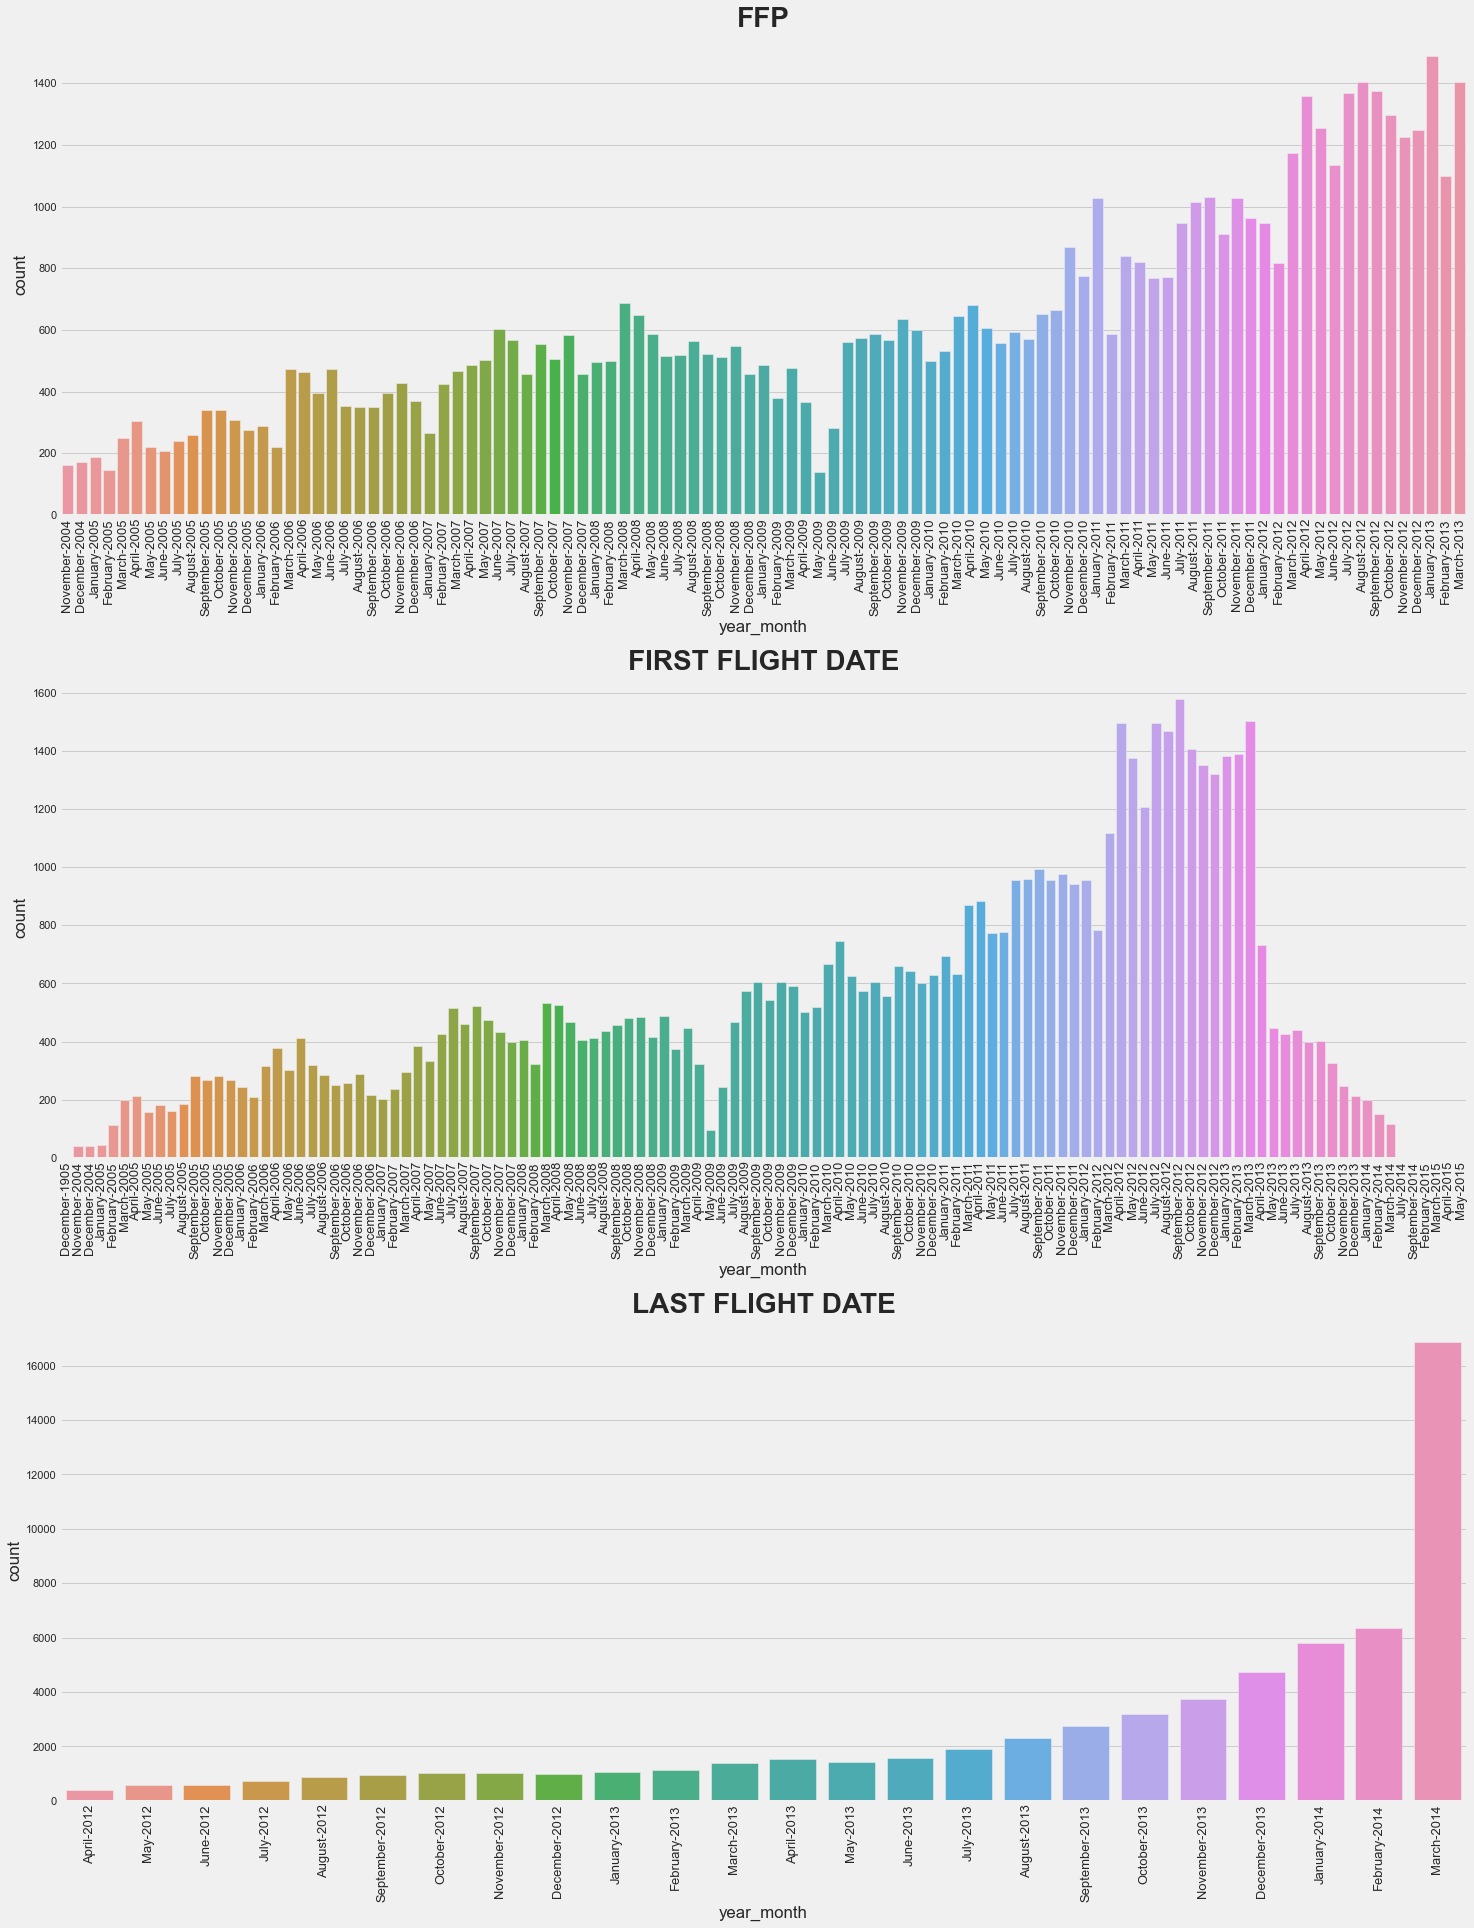

In [54]:
plt.figure(figsize = (20.7, 27))

for i in range(0, len(year_month_plot)):
    plt.subplot(3, 1, i + 1)
    sns.barplot(
        x = 'year_month',
        y = 'count',
        data = year_month_plot[i]
    )
    
    plt.xticks(fontsize = 13, rotation = 90)
    
    plt.title(title_date[i], fontsize = 28, fontweight = 'bold')
    
plt.tight_layout()

plt.savefig('fig/EDA/categorical-date-MY barplot.png', bbox_inches = 'tight')

##### Year

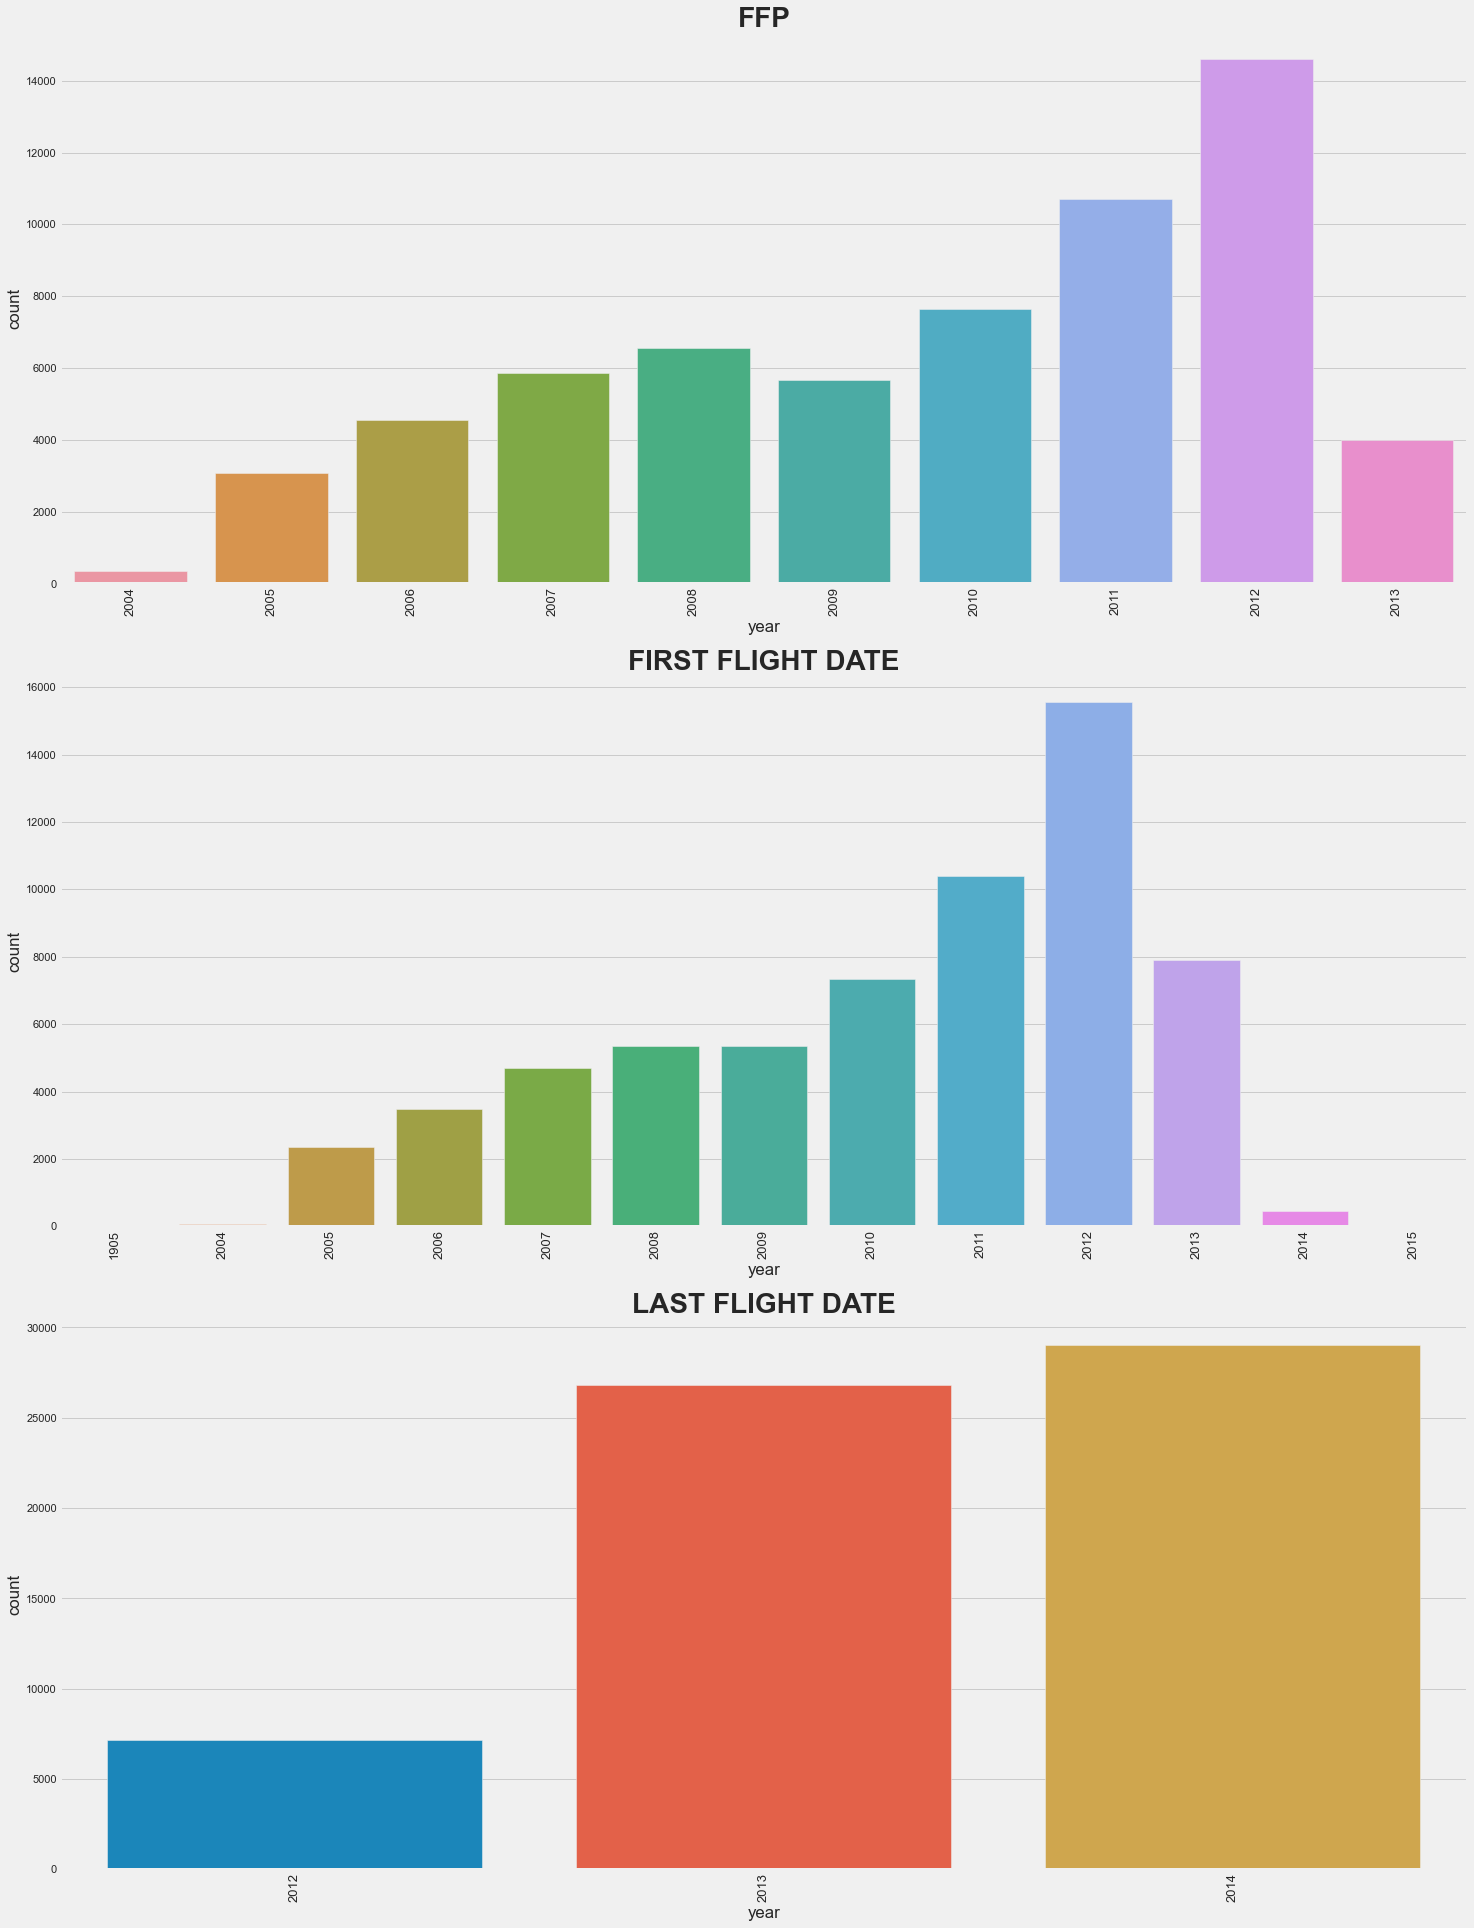

In [55]:
plt.figure(figsize = (20.7, 27))

for i in range(0, len(year_plot)):
    plt.subplot(3, 1, i + 1)
    sns.barplot(
        x = 'year',
        y = 'count',
        data = year_plot[i]
    )
    
    plt.xticks(fontsize = 13, rotation = 90)
    
    plt.title(title_date[i], fontsize = 28, fontweight = 'bold')
    
plt.tight_layout()

plt.savefig('fig/EDA/categorical-date-Y barplot.png', bbox_inches = 'tight')

#### Categorical Features with Excessive Amount of Unique Values.

In [56]:
data_copy['WORK_CITY'].value_counts().head(9)

guangzhou    9393
beijing      7859
shanghai     5012
shenzhen     3608
dalian       1980
shenyang     1626
changchun    1528
wulumuqi     1471
wuhan        1158
Name: WORK_CITY, dtype: int64

In [57]:
def group_city(x):
    if x['WORK_CITY'] == 'guangzhou':
        city = 'guangzhou'
    elif x['WORK_CITY'] == 'beijing':
        city = 'beijing'
    elif x['WORK_CITY'] == 'shanghai':
        city = 'shanghai'
    elif x['WORK_CITY'] == 'shenzhen':
        city = 'shenzhen'
    elif x['WORK_CITY'] == 'dalian':
        city = 'dalian'
    elif x['WORK_CITY'] == 'shenyang':
        city = 'shenyang'
    elif x['WORK_CITY'] == 'changchun':
        city = 'changchun'
    elif x['WORK_CITY'] == 'wulumuqi':
        city = 'wulumuqi'
    elif x['WORK_CITY'] == 'wuhan':
        city = 'wuhan'
    else:
        city = 'others'
    return city

In [58]:
data_copy['WORK_CITY_GROUP'] = data_copy.apply(lambda x: group_city(x), axis = 1)

In [59]:
data_copy['WORK_CITY_GROUP'].value_counts().head(10)

others       29353
guangzhou     9393
beijing       7859
shanghai      5012
shenzhen      3608
dalian        1980
shenyang      1626
changchun     1528
wulumuqi      1471
wuhan         1158
Name: WORK_CITY_GROUP, dtype: int64

In [60]:
data_copy.head()

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
0      54993  11/2/2006        12/24/2008   Male         6            .   
1      28065  2/19/2007          8/3/2007   Male         6          NaN   
2      55106   2/1/2007         8/30/2007   Male         6            .   
3      21189  8/22/2008         8/23/2008   Male         5  los angeles   
4      39546  4/10/2009         4/15/2009   Male         6      guiyang   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  ffp_month_name  \
0       beijing           CN  31.0  3/31/2014  ...        November   
1       beijing           CN  42.0  3/31/2014  ...        February   
2       beijing           CN  40.0  3/31/2014  ...        February   
3            ca           US  64.0  3/31/2014  ...          August   
4       guizhou           CN  48.0  3/31/2014  ...           April   

   FIRST_FLIGHT_IN_DATE  fflight_year  fflight_month  fflight_month_name  \
0            2008-12-24          2008             12            December   
1            2007-08-03          2007              8              August   
2            2007-08-30          2007              8              August   
3            2008-08-23          2008              8              August   
4            2009-04-15          2009              4               April   

  LAST_FLIGHT_IN_DATE  lflight_year  lflight_month  lflight_month_name  \
0          2014-03-31          2014              3               March   
1          2014-03-25          2014              3               March   
2          2014-03-21          2014              3               March   
3          2013-12-26          2013             12            December   
4          2014-03-27          2014              3               March   

   WORK_CITY_GROUP  
0           others  
1           others  
2           others  
3           others  
4           others  

[5 rows x 36 columns]

In [61]:
data_copy['WORK_PROVINCE'].value_counts().head(9)

guangdong       17519
beijing          8021
shanghai         5000
liaoning         4183
xinjiang         2512
jilin            1823
heilongjiang     1429
hubei            1379
henan            1187
Name: WORK_PROVINCE, dtype: int64

In [62]:
def group_province(x):
    if x['WORK_PROVINCE'] == 'guangdong':
        province = 'guangdong'
    elif x['WORK_PROVINCE'] == 'beijing':
        province = 'beijing'
    elif x['WORK_PROVINCE'] == 'shanghai':
        province = 'shanghai'
    elif x['WORK_PROVINCE'] == 'liaoning':
        province = 'liaoning'
    elif x['WORK_PROVINCE'] == 'xinjiang':
        province = 'xinjiang'
    elif x['WORK_PROVINCE'] == 'jilin':
        province = 'jilin'
    elif x['WORK_PROVINCE'] == 'heilongjiang':
        province = 'heilongjiang'
    elif x['WORK_PROVINCE'] == 'hubei':
        province = 'hubei'
    elif x['WORK_PROVINCE'] == 'henan':
        province = 'henan'
    else:
        province = 'others'
    return province

In [63]:
data_copy['WORK_PROVINCE_GROUP'] = data_copy.apply(lambda x: group_province(x), axis = 1)

In [64]:
data_copy['WORK_PROVINCE_GROUP'].value_counts().head(10)

others          19935
guangdong       17519
beijing          8021
shanghai         5000
liaoning         4183
xinjiang         2512
jilin            1823
heilongjiang     1429
hubei            1379
henan            1187
Name: WORK_PROVINCE_GROUP, dtype: int64

In [65]:
data_copy.head()

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
0      54993  11/2/2006        12/24/2008   Male         6            .   
1      28065  2/19/2007          8/3/2007   Male         6          NaN   
2      55106   2/1/2007         8/30/2007   Male         6            .   
3      21189  8/22/2008         8/23/2008   Male         5  los angeles   
4      39546  4/10/2009         4/15/2009   Male         6      guiyang   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  FIRST_FLIGHT_IN_DATE  \
0       beijing           CN  31.0  3/31/2014  ...            2008-12-24   
1       beijing           CN  42.0  3/31/2014  ...            2007-08-03   
2       beijing           CN  40.0  3/31/2014  ...            2007-08-30   
3            ca           US  64.0  3/31/2014  ...            2008-08-23   
4       guizhou           CN  48.0  3/31/2014  ...            2009-04-15   

   fflight_year  fflight_month  fflight_month_name  LAST_FLIGHT_IN_DATE  \
0          2008             12            December           2014-03-31   
1          2007              8              August           2014-03-25   
2          2007              8              August           2014-03-21   
3          2008              8              August           2013-12-26   
4          2009              4               April           2014-03-27   

  lflight_year  lflight_month  lflight_month_name  WORK_CITY_GROUP  \
0         2014              3               March           others   
1         2014              3               March           others   
2         2014              3               March           others   
3         2013             12            December           others   
4         2014              3               March           others   

   WORK_PROVINCE_GROUP  
0              beijing  
1              beijing  
2              beijing  
3               others  
4               others  

[5 rows x 37 columns]

In [66]:
data_copy['WORK_COUNTRY'].value_counts().head(9)

CN    57749
HK      991
JP      875
KR      790
US      575
SG      281
TW      281
AU      271
MY      161
Name: WORK_COUNTRY, dtype: int64

In [67]:
def group_country(x):
    if x['WORK_COUNTRY'] == 'CN':
        country = 'CN'
    elif x['WORK_COUNTRY'] == 'HK':
        country = 'HK'
    elif x['WORK_COUNTRY'] == 'JP':
        country = 'JP'
    elif x['WORK_COUNTRY'] == 'KR':
        country = 'KR'
    elif x['WORK_COUNTRY'] == 'US':
        country = 'US'
    elif x['WORK_COUNTRY'] == 'TW':
        country = 'TW'
    elif x['WORK_COUNTRY'] == 'SG':
        country = 'SG'
    elif x['WORK_COUNTRY'] == 'AU':
        country = 'AU'
    elif x['WORK_COUNTRY'] == 'MY':
        country = 'MY'
    else:
        country = 'others'
    return country

In [68]:
data_copy['WORK_COUNTRY_GROUP'] = data_copy.apply(lambda x: group_country(x), axis = 1)

In [69]:
data_copy['WORK_COUNTRY_GROUP'].value_counts().head(10)

CN        57749
others     1014
HK          991
JP          875
KR          790
US          575
SG          281
TW          281
AU          271
MY          161
Name: WORK_COUNTRY_GROUP, dtype: int64

In [70]:
data_copy.head()

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
0      54993  11/2/2006        12/24/2008   Male         6            .   
1      28065  2/19/2007          8/3/2007   Male         6          NaN   
2      55106   2/1/2007         8/30/2007   Male         6            .   
3      21189  8/22/2008         8/23/2008   Male         5  los angeles   
4      39546  4/10/2009         4/15/2009   Male         6      guiyang   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  fflight_year  \
0       beijing           CN  31.0  3/31/2014  ...          2008   
1       beijing           CN  42.0  3/31/2014  ...          2007   
2       beijing           CN  40.0  3/31/2014  ...          2007   
3            ca           US  64.0  3/31/2014  ...          2008   
4       guizhou           CN  48.0  3/31/2014  ...          2009   

   fflight_month  fflight_month_name  LAST_FLIGHT_IN_DATE  lflight_year  \
0             12            December           2014-03-31          2014   
1              8              August           2014-03-25          2014   
2              8              August           2014-03-21          2014   
3              8              August           2013-12-26          2013   
4              4               April           2014-03-27          2014   

  lflight_month  lflight_month_name  WORK_CITY_GROUP  WORK_PROVINCE_GROUP  \
0             3               March           others              beijing   
1             3               March           others              beijing   
2             3               March           others              beijing   
3            12            December           others               others   
4             3               March           others               others   

   WORK_COUNTRY_GROUP  
0                  CN  
1                  CN  
2                  CN  
3                  US  
4                  CN  

[5 rows x 38 columns]

#### PLOT Categorical-Nominal

In [71]:
features_cat_plot = ['WORK_CITY_GROUP', 'WORK_PROVINCE_GROUP', 'WORK_COUNTRY_GROUP']
title_cat_plot = ['WORK CITY GROUP', 'WORK PROVINCE GROUP', 'WORK COUNTRY GROUP']

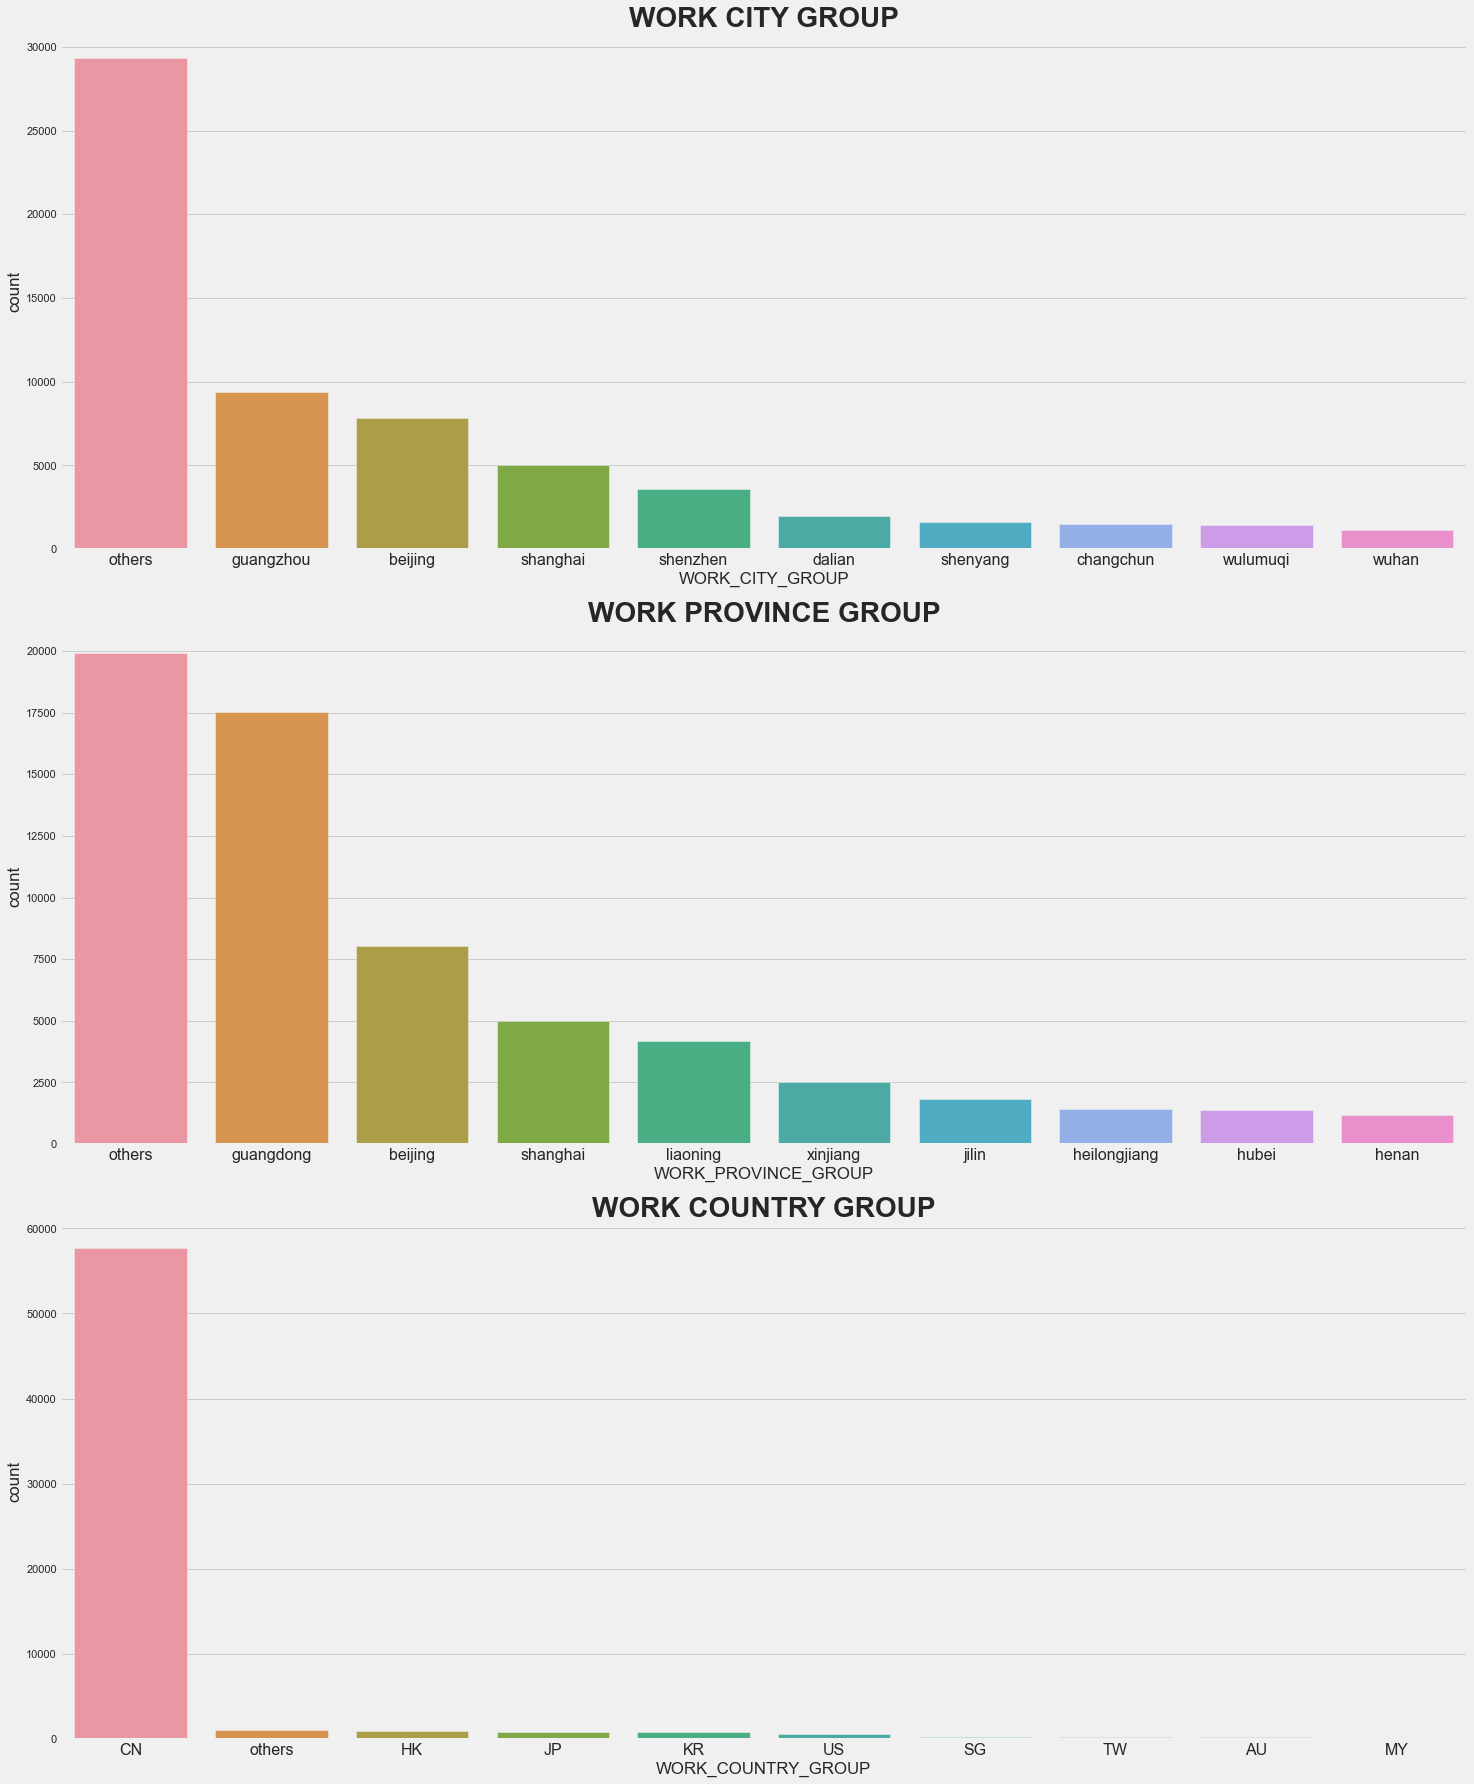

In [72]:
plt.figure(figsize = (20.7, 25))

for i in range(0, len(features_cat_plot)):
    plt.subplot(3, 1, i + 1)
    sns.countplot(
        x = features_cat_plot[i],
        order = data_copy[features_cat_plot[i]].value_counts().index,
        data = data_copy
    )
    
    plt.xticks(fontsize = 16)
    
    plt.title(title_cat_plot[i], fontsize = 28, fontweight = 'bold')

plt.tight_layout()

plt.savefig('fig/EDA/categorical-nominal countplot.png', bbox_inches = 'tight')

### PLOT Unique Value

In [73]:
categorical_unique = data_copy[features_cat].nunique().reset_index()
categorical_unique.columns = ['feature', '# unique value']
categorical_unique = categorical_unique.sort_values('# unique value', ascending = False).reset_index(drop = True)
categorical_unique

feature  # unique value
0  FIRST_FLIGHT_DATE            3406
1           FFP_DATE            3068
2          WORK_CITY            3068
3      WORK_PROVINCE            1045
4   LAST_FLIGHT_DATE             730
5       WORK_COUNTRY             117
6             GENDER               2
7          LOAD_TIME               1

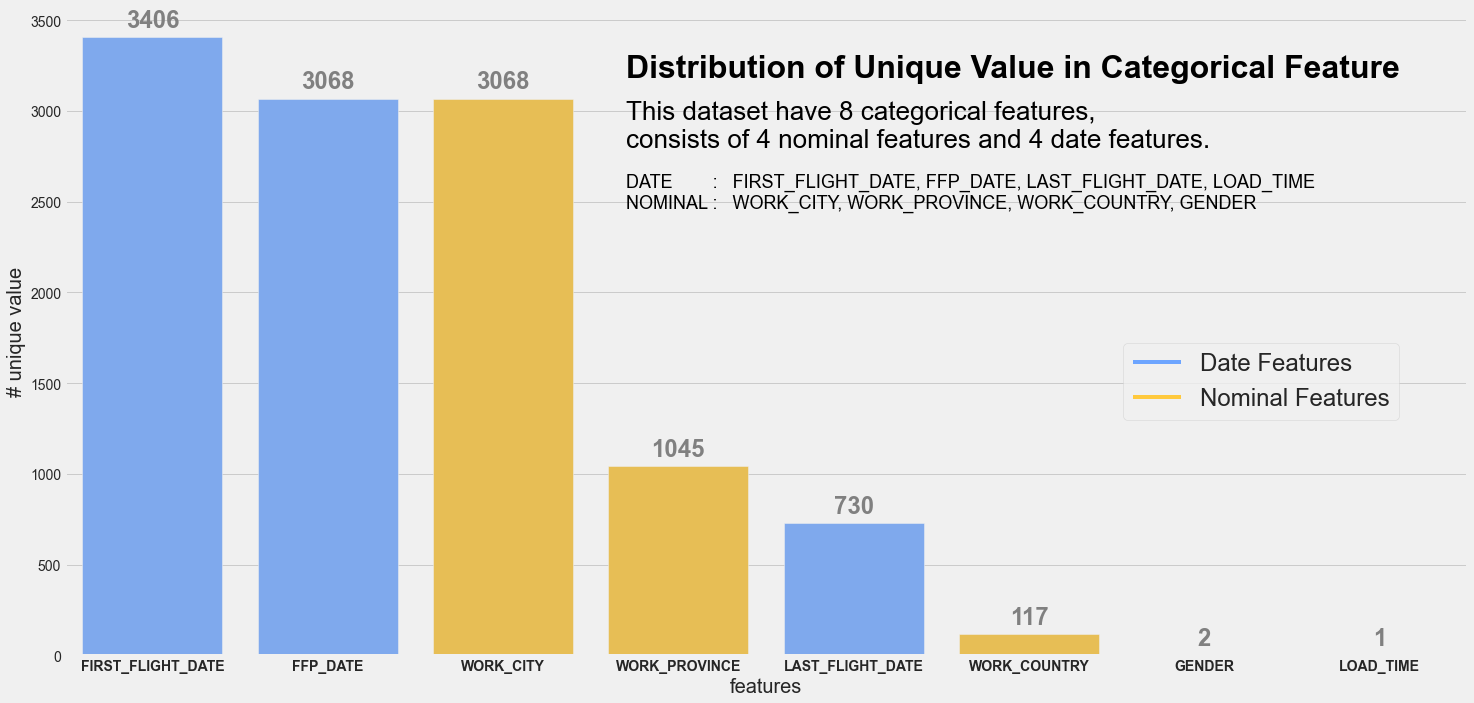

In [74]:
plt.figure(figsize = (20.7, 10))

legend_elements = [
    Line2D([0], [0], color = '#6DA5FF', lw = 4, label = 'Date Features'),
    Line2D([0], [0], color = '#FFC93D', lw = 4, label = 'Nominal Features')
]

ax = sns.barplot(
    x = 'feature',
    y = '# unique value',
    data = categorical_unique,
    palette = ['#6DA5FF', '#6DA5FF', '#FFC93D', '#FFC93D', '#6DA5FF', '#FFC93D', '#FFC93D', '#6DA5FF']
)

ax.legend(handles = legend_elements, bbox_to_anchor = (0.96, 0.5), loc = 'upper right', fontsize = 24)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 24,
        xytext = (0, 10), 
        textcoords = 'offset points',
        color = 'gray'
    )

title = '''
Distribution of Unique Value in Categorical Feature
'''
ax.text(2.7, 3000, title, ha = 'left', color = 'black', fontsize = 32, fontweight = 'bold')

text1 = '''
This dataset have 8 categorical features,
consists of 4 nominal features and 4 date features.
'''

ax.text(2.7, 2650, text1, ha = 'left', color = 'black', fontsize = 26, fontweight = 'normal')

text2 = '''
DATE        :   FIRST_FLIGHT_DATE, FFP_DATE, LAST_FLIGHT_DATE, LOAD_TIME
NOMINAL :   WORK_CITY, WORK_PROVINCE, WORK_COUNTRY, GENDER
'''

ax.text(2.7, 2350, text2, ha = 'left', color = 'black', fontsize = 18, fontweight = 'normal')

plt.xticks(fontsize = 14, fontweight = 'semibold')
plt.yticks(fontsize = 14)

plt.xlabel('features', fontsize = 20)
plt.ylabel('# unique value', fontsize = 20)

plt.tight_layout()

plt.savefig('fig/EDA/categorical-unique value barplot.png', bbox_inches = 'tight')

### PLOT Missing Value

In [75]:
# check number of NaN or null value in each column
data_copy.isnull().sum()

MEMBER_NO                  0
FFP_DATE                   0
FIRST_FLIGHT_DATE          0
GENDER                     3
FFP_TIER                   0
WORK_CITY               2269
WORK_PROVINCE           3248
WORK_COUNTRY              26
AGE                      420
LOAD_TIME                  0
FLIGHT_COUNT               0
BP_SUM                     0
SUM_YR_1                 551
SUM_YR_2                 138
SEG_KM_SUM                 0
LAST_FLIGHT_DATE           0
LAST_TO_END                0
AVG_INTERVAL               0
MAX_INTERVAL               0
EXCHANGE_COUNT             0
avg_discount               0
Points_Sum                 0
Point_NotFlight            0
FFP_IN_DATE                0
ffp_year                   0
ffp_month                  0
ffp_month_name             0
FIRST_FLIGHT_IN_DATE       0
fflight_year               0
fflight_month              0
fflight_month_name         0
LAST_FLIGHT_IN_DATE        0
lflight_year               0
lflight_month              0
lflight_month_

In [76]:
categorical_null = data_copy.isnull().sum().reset_index()
categorical_null.columns = ['feature', '# missing value']
categorical_null = categorical_null.sort_values('# missing value', ascending = False).reset_index(drop = True).head(7)
categorical_null

feature  # missing value
0  WORK_PROVINCE             3248
1      WORK_CITY             2269
2       SUM_YR_1              551
3            AGE              420
4       SUM_YR_2              138
5   WORK_COUNTRY               26
6         GENDER                3

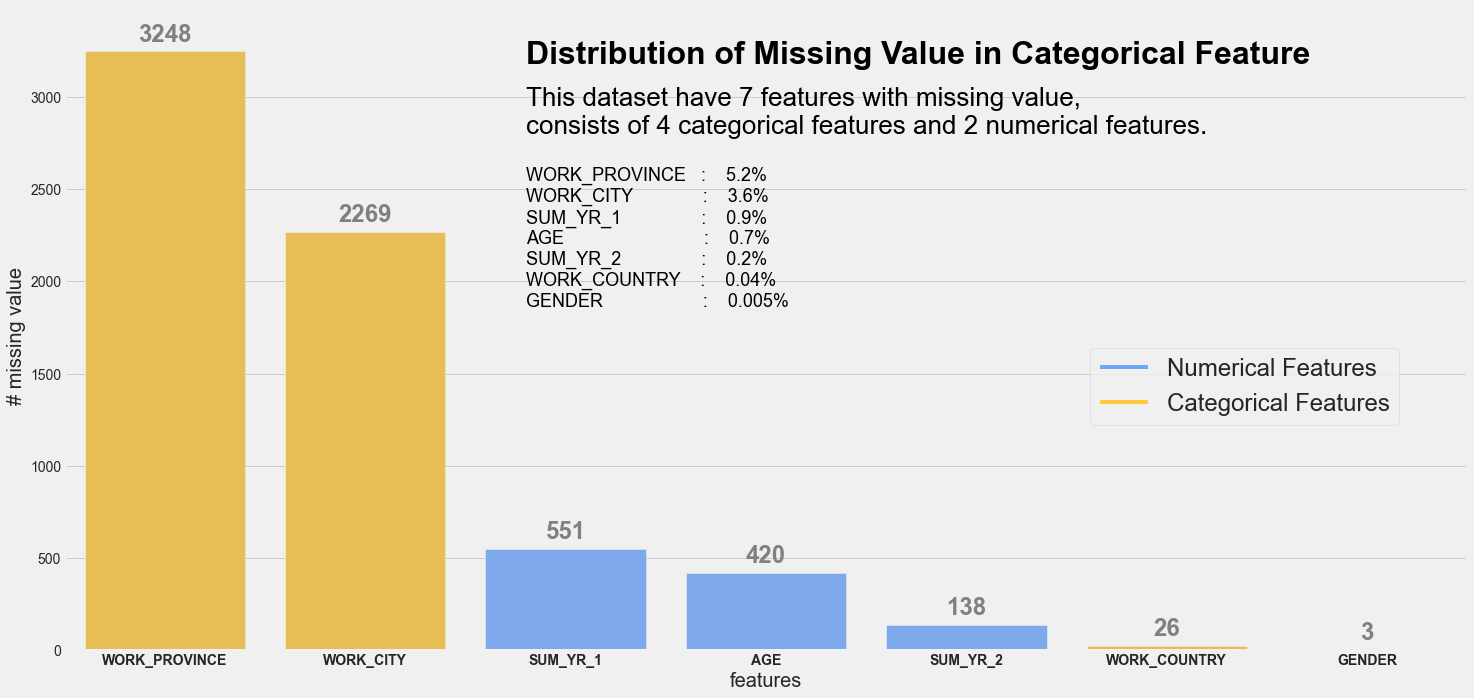

In [77]:
plt.figure(figsize = (20.7, 10))

legend_elements = [
    Line2D([0], [0], color = '#6DA5FF', lw = 4, label = 'Numerical Features'),
    Line2D([0], [0], color = '#FFC93D', lw = 4, label = 'Categorical Features')
]

ax = sns.barplot(
    x = 'feature',
    y = '# missing value',
    data = categorical_null,
    palette = ['#FFC93D', '#FFC93D', '#6DA5FF', '#6DA5FF', '#6DA5FF', '#FFC93D', '#FFC93D']
)

ax.legend(handles = legend_elements, bbox_to_anchor = (0.96, 0.5), loc = 'upper right', fontsize = 24)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 24,
        xytext = (0, 10), 
        textcoords = 'offset points',
        color = 'gray'
    )

title = '''
Distribution of Missing Value in Categorical Feature
'''
ax.text(1.8, 3000, title, ha = 'left', color = 'black', fontsize = 32, fontweight = 'bold')

text1 = '''
This dataset have 7 features with missing value,
consists of 4 categorical features and 2 numerical features.
'''

ax.text(1.8, 2650, text1, ha = 'left', color = 'black', fontsize = 26, fontweight = 'normal')

text2 = '''
WORK_PROVINCE   :    5.2%
WORK_CITY              :    3.6%
SUM_YR_1                :    0.9%
AGE                            :    0.7%
SUM_YR_2                :    0.2%
WORK_COUNTRY    :    0.04%
GENDER                    :    0.005%
'''

ax.text(1.8, 1750, text2, ha = 'left', color = 'black', fontsize = 18, fontweight = 'normal')

plt.xticks(fontsize = 14, fontweight = 'semibold')
plt.yticks(fontsize = 14)

plt.xlabel('features', fontsize = 20)
plt.ylabel('# missing value', fontsize = 20)

plt.tight_layout()

plt.savefig('fig/EDA/categorical-missing value barplot.png', bbox_inches = 'tight')

# Data Preprocessing

In [78]:
data_preprocess = data.copy()
data_preprocess.head()

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
0      54993  11/2/2006        12/24/2008   Male         6            .   
1      28065  2/19/2007          8/3/2007   Male         6          NaN   
2      55106   2/1/2007         8/30/2007   Male         6            .   
3      21189  8/22/2008         8/23/2008   Male         5  Los Angeles   
4      39546  4/10/2009         4/15/2009   Male         6      guiyang   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  SUM_YR_2  SEG_KM_SUM  \
0       beijing           CN  31.0  3/31/2014  ...  234188.0      580717   
1       beijing           CN  42.0  3/31/2014  ...  167434.0      293678   
2       beijing           CN  40.0  3/31/2014  ...  164982.0      283712   
3            CA           US  64.0  3/31/2014  ...  125500.0      281336   
4       guizhou           CN  48.0  3/31/2014  ...  130702.0      309928   

   LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL MAX_INTERVAL  EXCHANGE_COUNT  \
0         3/31/2014            1      3.483254           18              34   
1         3/25/2014            7      5.194245           17              29   
2         3/21/2014           11      5.298507           18              20   
3        12/26/2013           97     27.863636           73              11   
4         3/27/2014            5      4.788079           47              27   

   avg_discount  Points_Sum  Point_NotFlight  
0      0.961639      619760               50  
1      1.252314      415768               33  
2      1.254676      406361               26  
3      1.090870      372204               12  
4      0.970658      338813               39  

[5 rows x 23 columns]

## Feature selection

- We will analyze customer segmentation based on LRFMC Model
- Source: Analysis Method for Customer Value of Aviation Big Data Based on LRFMC Model
- https://link.springer.com/chapter/10.1007/978-981-15-7981-3_7

What is LRFMC Model?
- L : The number of months since the member’s joining time from the end of the observation time
- R : Number of months since the member’s last flight from the end of observation time
- F : The total number of times the member has flown during the observation period
- M : Miles accumulated during member observation time
- C : The average value of the discount factor used by the member during the observation period

According to the LRFMC model of airline customer value, six features related to the LRFMC model indexes are selected:
- FFP_DATE
- LOAD_TIME
- FLIGHT_COUNT
- avg_discount
- SEG_KM_SUM
- LAST_TO_END

We have one feature that needs to extracted in the **feature extraction** step, which is **'L'** the number of months since the member's joining time from the end of the observation time.

- L = LOAD_TIME - FFP_DATE
 - The number of months between the time of membership and the end of observation window = the end time of observation window - the time of membership [unit: month].

- R = LAST_TO_END
 - The number of months from the last time the customer took the company’s aircraft to the end of the observation window = the time from the last flight to the end of the observation window [unit: month]
 
- F = FLIGHT_COUNT
 - Number of times the customer takes the company’s aircraft in the observation window = number of flights in the observation window [unit: Times].
 
- M = SEG_KM_SUM
 - Accumulated flight history of the customer in observation time = total flight kilometers of observation window [unit: km].
 
- C = avg_discount
 - Average value of the discount coefficient corresponding to the passenger space during the observation time = average discount rate [unit: none].


**Based on the previous explanation, we will only use related features listed above and ignore the rest.**

But before choosing them, make sure to check **any missing values** as the next part.

In [79]:
selected_features = [
    'FFP_DATE',
    'LOAD_TIME',
    'FLIGHT_COUNT',
    'avg_discount',
    'SEG_KM_SUM',
    'LAST_TO_END'
]
selected_features

['FFP_DATE',
 'LOAD_TIME',
 'FLIGHT_COUNT',
 'avg_discount',
 'SEG_KM_SUM',
 'LAST_TO_END']

In [80]:
data_preprocess[selected_features].head()

FFP_DATE  LOAD_TIME  FLIGHT_COUNT  avg_discount  SEG_KM_SUM  LAST_TO_END
0  11/2/2006  3/31/2014           210      0.961639      580717            1
1  2/19/2007  3/31/2014           140      1.252314      293678            7
2   2/1/2007  3/31/2014           135      1.254676      283712           11
3  8/22/2008  3/31/2014            23      1.090870      281336           97
4  4/10/2009  3/31/2014           152      0.970658      309928            5

## New Feature

### Membership Duration in Month

- L = LOAD_TIME - FFP_DATE
    - The number of months between the time of membership and the end of observation window = the end time of observation window - the time of membership [unit: month].

In [81]:
data_preprocess[['LOAD_TIME', 'FFP_DATE']].head()

LOAD_TIME   FFP_DATE
0  3/31/2014  11/2/2006
1  3/31/2014  2/19/2007
2  3/31/2014   2/1/2007
3  3/31/2014  8/22/2008
4  3/31/2014  4/10/2009

- These 2 features are not in an acceptable form to proceed, therefore we need to transform them using pandas to_datetime.

In [82]:
data_preprocess['FFP_IN_DATE'] = data_preprocess['FFP_DATE'].apply(lambda x: pd.to_datetime(x))

In [83]:
data_preprocess['LOAD_TIME_IN_DATE'] = data_preprocess['LOAD_TIME'].apply(lambda x: pd.to_datetime(x))

In [84]:
data_preprocess.head()

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
0      54993  11/2/2006        12/24/2008   Male         6            .   
1      28065  2/19/2007          8/3/2007   Male         6          NaN   
2      55106   2/1/2007         8/30/2007   Male         6            .   
3      21189  8/22/2008         8/23/2008   Male         5  Los Angeles   
4      39546  4/10/2009         4/15/2009   Male         6      guiyang   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  LAST_FLIGHT_DATE  \
0       beijing           CN  31.0  3/31/2014  ...         3/31/2014   
1       beijing           CN  42.0  3/31/2014  ...         3/25/2014   
2       beijing           CN  40.0  3/31/2014  ...         3/21/2014   
3            CA           US  64.0  3/31/2014  ...        12/26/2013   
4       guizhou           CN  48.0  3/31/2014  ...         3/27/2014   

   LAST_TO_END  AVG_INTERVAL  MAX_INTERVAL  EXCHANGE_COUNT avg_discount  \
0            1      3.483254            18              34     0.961639   
1            7      5.194245            17              29     1.252314   
2           11      5.298507            18              20     1.254676   
3           97     27.863636            73              11     1.090870   
4            5      4.788079            47              27     0.970658   

   Points_Sum  Point_NotFlight  FFP_IN_DATE  LOAD_TIME_IN_DATE  
0      619760               50   2006-11-02         2014-03-31  
1      415768               33   2007-02-19         2014-03-31  
2      406361               26   2007-02-01         2014-03-31  
3      372204               12   2008-08-22         2014-03-31  
4      338813               39   2009-04-10         2014-03-31  

[5 rows x 25 columns]

In [85]:
def months_membership(x):
    
    diff = relativedelta.relativedelta(x['LOAD_TIME_IN_DATE'], x['FFP_IN_DATE'])
    ffp_month_count = diff.years * 12 + diff.months
    
    return ffp_month_count

In [86]:
data_preprocess['MEMBERSHIP_MONTH_COUNT'] = data_preprocess.apply(lambda x: months_membership(x), axis = 1)

In [87]:
data_preprocess

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE  GENDER  FFP_TIER    WORK_CITY  \
0          54993  11/2/2006        12/24/2008    Male         6            .   
1          28065  2/19/2007          8/3/2007    Male         6          NaN   
2          55106   2/1/2007         8/30/2007    Male         6            .   
3          21189  8/22/2008         8/23/2008    Male         5  Los Angeles   
4          39546  4/10/2009         4/15/2009    Male         6      guiyang   
...          ...        ...               ...     ...       ...          ...   
62983      18375  5/20/2011          6/5/2013  Female         4    guangzhou   
62984      36041   3/8/2010         9/14/2013    Male         4       foshan   
62985      45690  3/30/2006         12/2/2006  Female         4    guangzhou   
62986      61027   2/6/2013         2/14/2013  Female         4    guangzhou   
62987      61340  2/17/2013         2/17/2013  Female         4     shanghai   

      WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  LAST_TO_END  \
0           beijing           CN  31.0  3/31/2014  ...            1   
1           beijing           CN  42.0  3/31/2014  ...            7   
2           beijing           CN  40.0  3/31/2014  ...           11   
3                CA           US  64.0  3/31/2014  ...           97   
4           guizhou           CN  48.0  3/31/2014  ...            5   
...             ...          ...   ...        ...  ...          ...   
62983     guangdong           CN  25.0  3/31/2014  ...          297   
62984     guangdong           CN  38.0  3/31/2014  ...           89   
62985     guangdong           CN  43.0  3/31/2014  ...           29   
62986     guangdong           CN  36.0  3/31/2014  ...          400   
62987             .           CN  29.0  3/31/2014  ...          403   

       AVG_INTERVAL  MAX_INTERVAL  EXCHANGE_COUNT  avg_discount Points_Sum  \
0          3.483254            18              34      0.961639     619760   
1          5.194245            17              29      1.252314     415768   
2          5.298507            18              20      1.254676     406361   
3         27.863636            73              11      1.090870     372204   
4          4.788079            47              27      0.970658     338813   
...             ...           ...             ...           ...        ...   
62983      4.000000             4               1      0.000000      12318   
62984     37.000000            60              14      0.000000     106972   
62985    166.000000           166               0      0.000000          0   
62986     12.000000            12               0      0.000000          0   
62987      6.000000             6               0      0.000000          0   

       Point_NotFlight  FFP_IN_DATE  LOAD_TIME_IN_DATE  MEMBERSHIP_MONTH_COUNT  
0                   50   2006-11-02         2014-03-31                      88  
1                   33   2007-02-19         2014-03-31                      85  
2                   26   2007-02-01         2014-03-31                      85  
3                   12   2008-08-22         2014-03-31                      67  
4                   39   2009-04-10         2014-03-31                      59  
...                ...          ...                ...                     ...  
62983               22   2011-05-20         2014-03-31                      34  
62984               43   2010-03-08         2014-03-31                      48  
62985                0   2006-03-30         2014-03-31                      96  
62986                0   2013-02-06         2014-03-31                      13  
62987                0   2013-02-17         2014-03-31                      13  

[62988 rows x 26 columns]

In [88]:
data_preprocess[['MEMBERSHIP_MONTH_COUNT', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']].reset_index(drop = True)

MEMBERSHIP_MONTH_COUNT  LAST_TO_END  FLIGHT_COUNT  SEG_KM_SUM  \
0                          88            1           210      580717   
1                          85            7           140      293678   
2                          85           11           135      283712   
3                          67           97            23      281336   
4                          59            5           152      309928   
...                       ...          ...           ...         ...   
62983                      34          297             2        1134   
62984                      48           89             4        8016   
62985                      96           29             2        2594   
62986                      13          400             2        3934   
62987                      13          403             2        4222   

       avg_discount  
0          0.961639  
1          1.252314  
2          1.254676  
3          1.090870  
4          0.970658  
...             ...  
62983      0.000000  
62984      0.000000  
62985      0.000000  
62986      0.000000  
62987      0.000000  

[62988 rows x 5 columns]

## Missing Value

In [89]:
data_preprocess.isnull().sum()

MEMBER_NO                    0
FFP_DATE                     0
FIRST_FLIGHT_DATE            0
GENDER                       3
FFP_TIER                     0
WORK_CITY                 2269
WORK_PROVINCE             3248
WORK_COUNTRY                26
AGE                        420
LOAD_TIME                    0
FLIGHT_COUNT                 0
BP_SUM                       0
SUM_YR_1                   551
SUM_YR_2                   138
SEG_KM_SUM                   0
LAST_FLIGHT_DATE             0
LAST_TO_END                  0
AVG_INTERVAL                 0
MAX_INTERVAL                 0
EXCHANGE_COUNT               0
avg_discount                 0
Points_Sum                   0
Point_NotFlight              0
FFP_IN_DATE                  0
LOAD_TIME_IN_DATE            0
MEMBERSHIP_MONTH_COUNT       0
dtype: int64

From the above part, we could see the features that we will use do not have any missing values, therefore we could proceed with them.

In [90]:
features_ready = [
    'MEMBERSHIP_MONTH_COUNT',
    'LAST_TO_END',
    'FLIGHT_COUNT',
    'SEG_KM_SUM',
    'avg_discount'
]

print(data_preprocess[features_ready].shape)
data_preprocess[features_ready].head()

(62988, 5)


MEMBERSHIP_MONTH_COUNT  LAST_TO_END  FLIGHT_COUNT  SEG_KM_SUM  avg_discount
0                      88            1           210      580717      0.961639
1                      85            7           140      293678      1.252314
2                      85           11           135      283712      1.254676
3                      67           97            23      281336      1.090870
4                      59            5           152      309928      0.970658

## Outlier Treatment

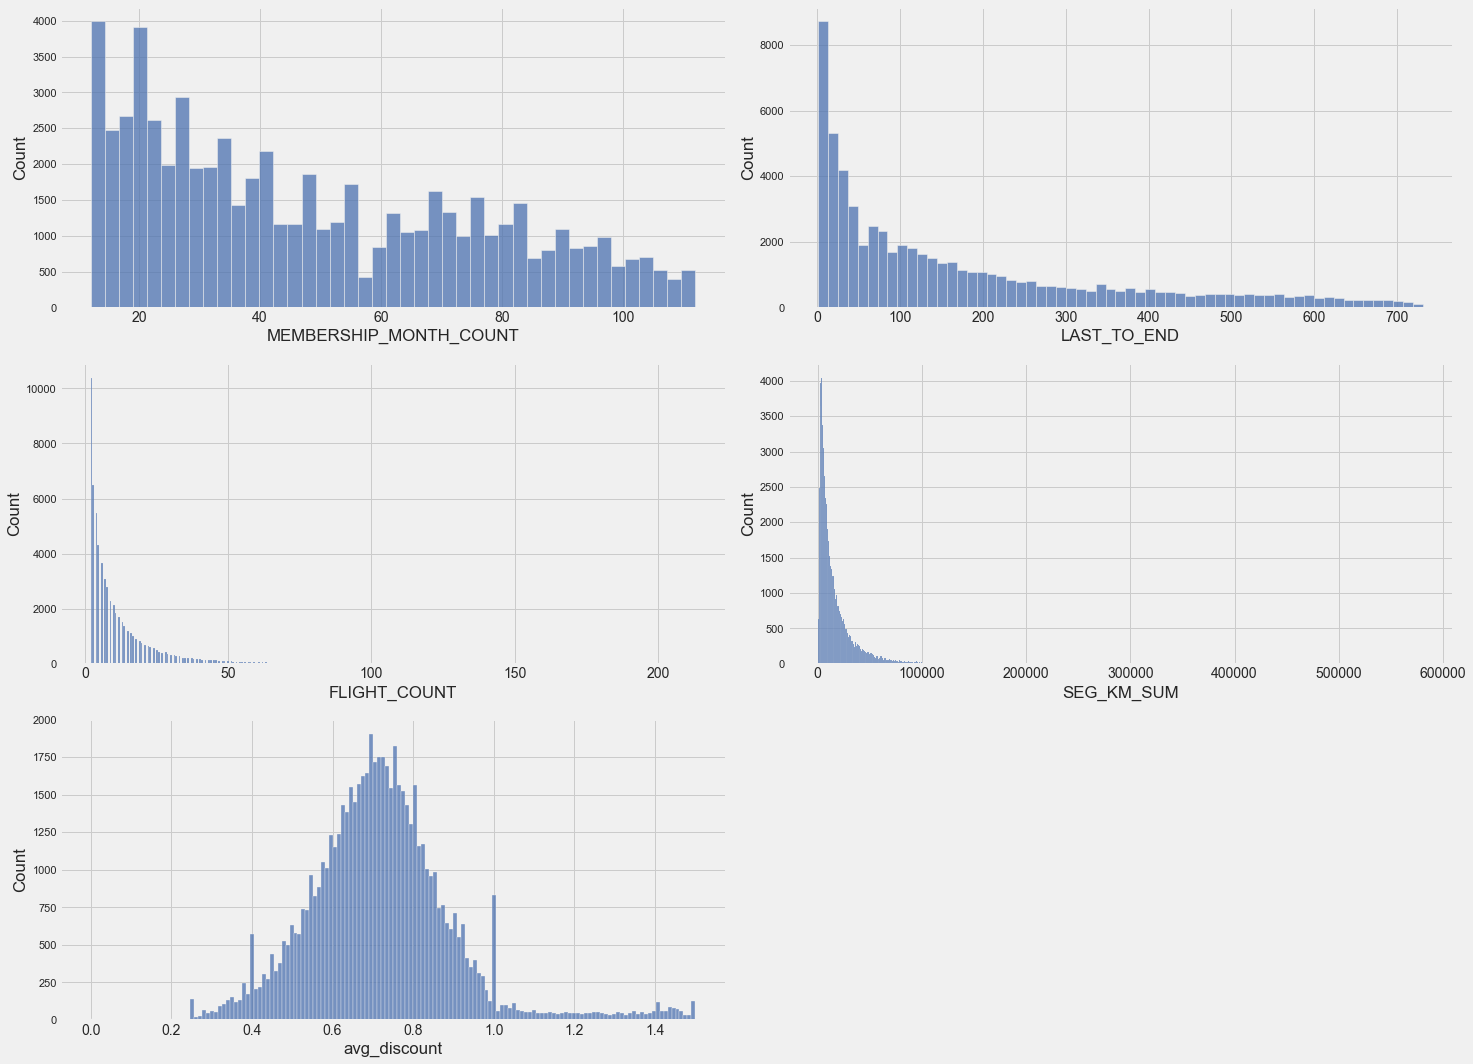

In [91]:
plt.figure(figsize = (20.7, 15))

for i in range(len(features_ready)):
    plt.subplot(3, 2, i + 1)
    sns.histplot(
        x = data_preprocess[features_ready[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/outlier histplot.png', bbox_inches = 'tight')

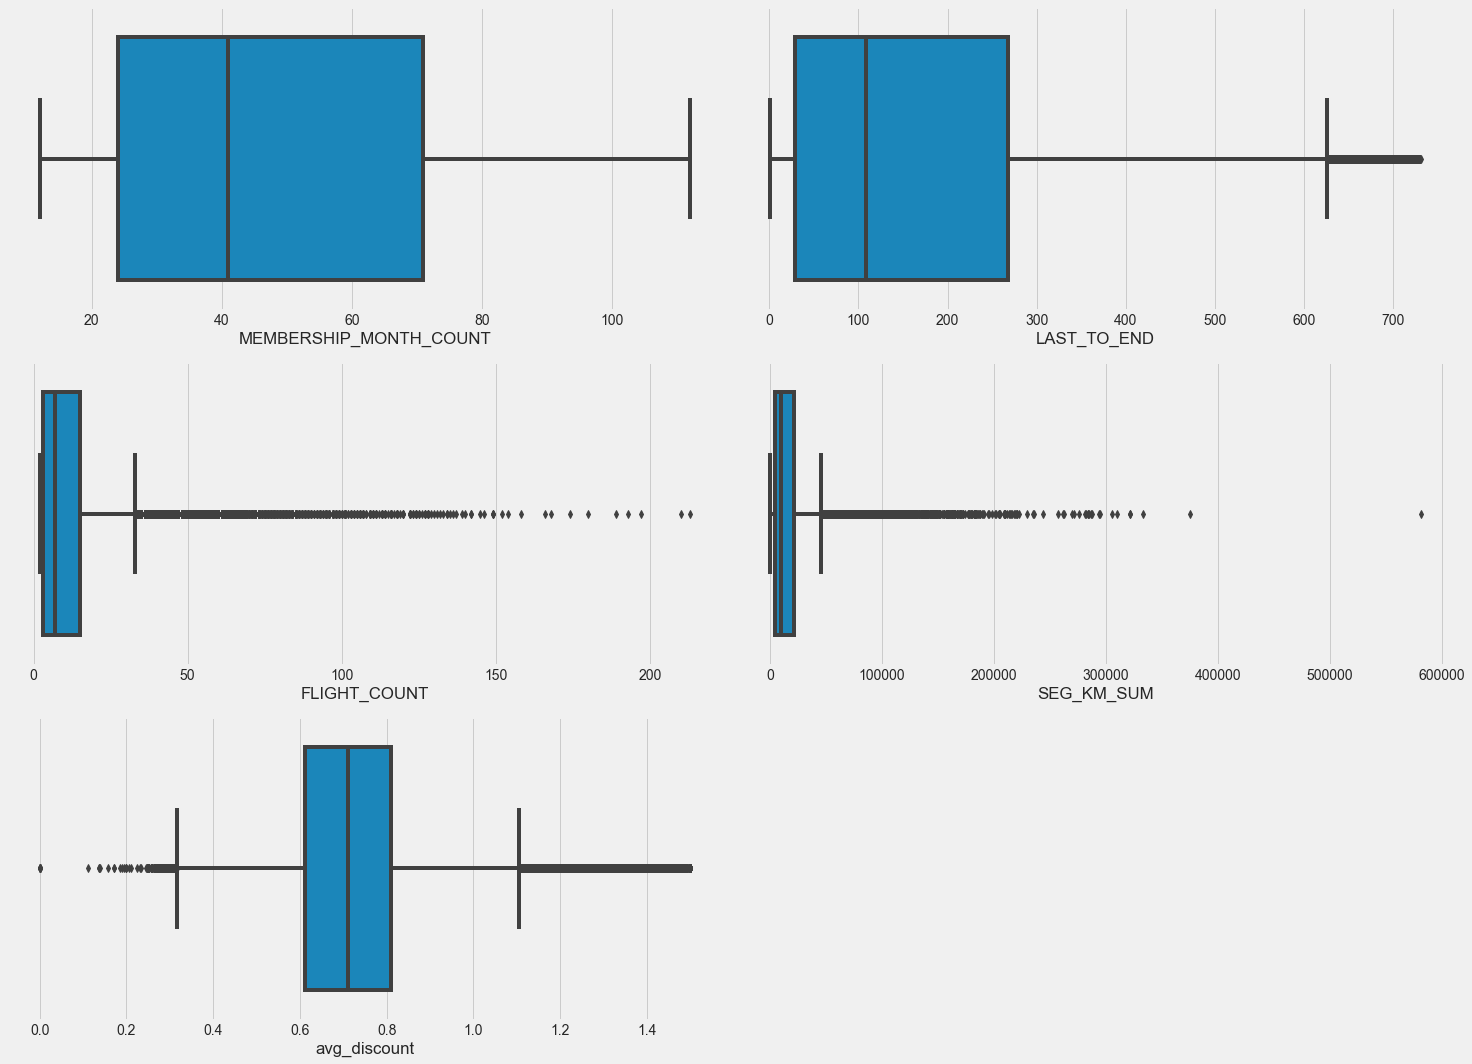

In [92]:
plt.figure(figsize = (20.7, 15))

for i in range(len(features_ready)):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(
        x = data_preprocess[features_ready[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/outlier boxplot.png', bbox_inches = 'tight')

In [93]:
data_preprocess[features_ready].skew()

MEMBERSHIP_MONTH_COUNT    0.522092
LAST_TO_END               1.178071
FLIGHT_COUNT              3.215305
SEG_KM_SUM                3.884612
avg_discount              0.956793
dtype: float64

- All of the selected features have skewness > 0.5, which means all of them are not fairly symmetrical. We need to treat the outliers.

### L: MEMBERSHIP_MONTH_COUNT

#### Log Transformation using log1p

In [94]:
data_preprocess['MEMBERSHIP_MONTH_COUNT_log'] = np.log1p(data_preprocess['MEMBERSHIP_MONTH_COUNT'])
data_preprocess[['MEMBERSHIP_MONTH_COUNT', 'MEMBERSHIP_MONTH_COUNT_log']].describe()

MEMBERSHIP_MONTH_COUNT  MEMBERSHIP_MONTH_COUNT_log
count            62988.000000                62988.000000
mean                48.318426                    3.722836
std                 27.826279                    0.612779
min                 12.000000                    2.564949
25%                 24.000000                    3.218876
50%                 41.000000                    3.737670
75%                 71.000000                    4.276666
max                112.000000                    4.727388

In [95]:
data_preprocess[['MEMBERSHIP_MONTH_COUNT', 'MEMBERSHIP_MONTH_COUNT_log']].skew()

MEMBERSHIP_MONTH_COUNT        0.522092
MEMBERSHIP_MONTH_COUNT_log   -0.169225
dtype: float64

#### Remove outlier

In [96]:
before_l = data_preprocess.shape[0]
before_l

62988

In [97]:
data_preprocess[['MEMBERSHIP_MONTH_COUNT_log']].skew()

MEMBERSHIP_MONTH_COUNT_log   -0.169225
dtype: float64

In [98]:
Q1 = data_preprocess['MEMBERSHIP_MONTH_COUNT_log'].quantile(0.25)
Q3 = data_preprocess['MEMBERSHIP_MONTH_COUNT_log'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)

print(low_limit)
print(high_limit)

1.6321903836464184
5.863351560237837


In [99]:
filtered_entries = ((data_preprocess['MEMBERSHIP_MONTH_COUNT_log'] >= low_limit) & (data_preprocess['MEMBERSHIP_MONTH_COUNT_log'] <= high_limit))
data_preprocess = data_preprocess[filtered_entries].reset_index(drop = True)
after_l = data_preprocess.shape[0]
after_l

62988

In [100]:
print('We removed', round((before_l - after_l)*100/before_l,2), '% of rows due to outlier.')

We removed 0.0 % of rows due to outlier.


In [101]:
data_preprocess[['MEMBERSHIP_MONTH_COUNT', 'MEMBERSHIP_MONTH_COUNT_log']].skew()

MEMBERSHIP_MONTH_COUNT        0.522092
MEMBERSHIP_MONTH_COUNT_log   -0.169225
dtype: float64

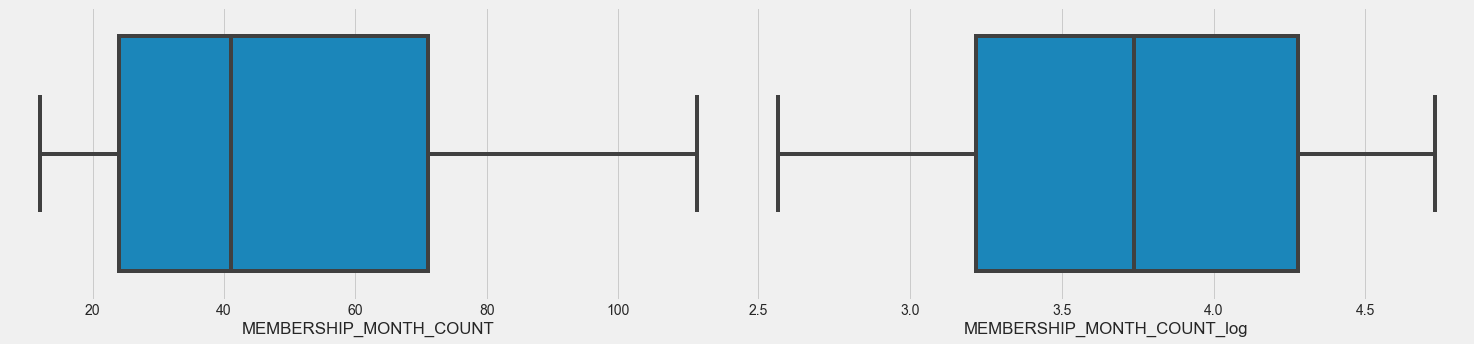

In [102]:
list_L = ['MEMBERSHIP_MONTH_COUNT', 'MEMBERSHIP_MONTH_COUNT_log']

plt.figure(figsize = (20.7, 5))

for i in range(0, len(list_L)):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(
        x = data_preprocess[list_L[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/MEMBERSHIP_MONTH_COUNT outlier boxplot.png', bbox_inches = 'tight')

### R: LAST_TO_END

#### Log Transformation using log1p

In [103]:
data_preprocess['LAST_TO_END_log'] = np.log1p(data_preprocess['LAST_TO_END'])
data_preprocess[['LAST_TO_END', 'LAST_TO_END_log']].describe()

LAST_TO_END  LAST_TO_END_log
count  62988.000000     62988.000000
mean     176.120102         4.413133
std      183.822223         1.465865
min        1.000000         0.693147
25%       29.000000         3.401197
50%      108.000000         4.691348
75%      268.000000         5.594711
max      731.000000         6.595781

In [104]:
data_preprocess[['LAST_TO_END', 'LAST_TO_END_log']].skew()

LAST_TO_END        1.178071
LAST_TO_END_log   -0.596959
dtype: float64

#### Remove outlier

In [105]:
before_l = data_preprocess.shape[0]
before_l

62988

In [106]:
data_preprocess[['LAST_TO_END_log']].skew()

LAST_TO_END_log   -0.596959
dtype: float64

In [107]:
Q1 = data_preprocess['LAST_TO_END_log'].quantile(0.25)
Q3 = data_preprocess['LAST_TO_END_log'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)

print(low_limit)
print(high_limit)

0.11092638475263028
8.884982376511363


In [108]:
filtered_entries = ((data_preprocess['LAST_TO_END_log'] >= low_limit) & (data_preprocess['LAST_TO_END_log'] <= high_limit))
data_preprocess = data_preprocess[filtered_entries].reset_index(drop = True)
after_l = data_preprocess.shape[0]
after_l

62988

In [109]:
print('We removed', round((before_l - after_l)*100/before_l,2), '% of rows due to outlier.')

We removed 0.0 % of rows due to outlier.


In [110]:
data_preprocess[['LAST_TO_END', 'LAST_TO_END_log']].skew()

LAST_TO_END        1.178071
LAST_TO_END_log   -0.596959
dtype: float64

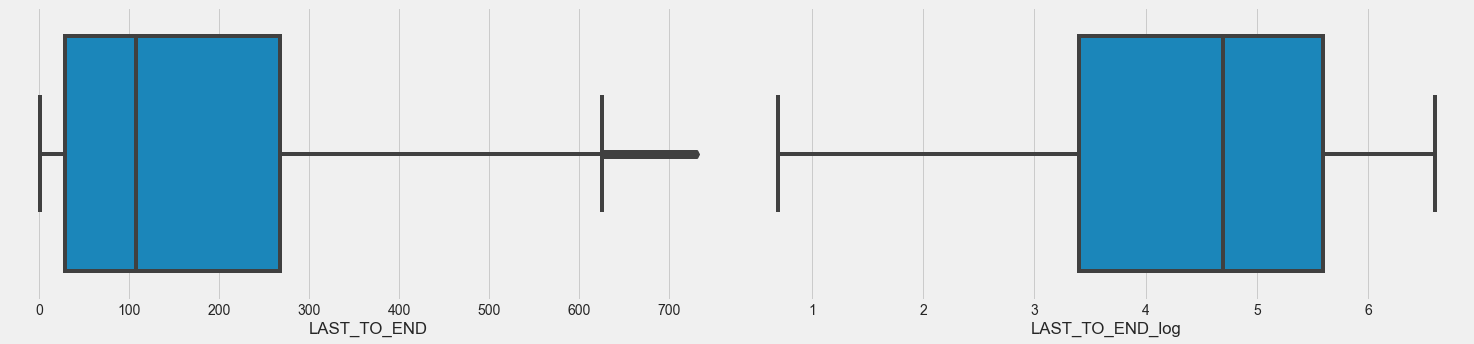

In [111]:
list_R = ['LAST_TO_END', 'LAST_TO_END_log']

plt.figure(figsize = (20.7, 5))

for i in range(0, len(list_R)):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(
        x = data_preprocess[list_R[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/LAST_TO_END outlier boxplot.png', bbox_inches = 'tight')

### F: FLIGHT_COUNT

#### Log Transformation using log1p

In [112]:
data_preprocess['FLIGHT_COUNT_log'] = np.log1p(data_preprocess['FLIGHT_COUNT'])
data_preprocess[['FLIGHT_COUNT', 'FLIGHT_COUNT_log']].describe()

FLIGHT_COUNT  FLIGHT_COUNT_log
count  62988.000000      62988.000000
mean      11.839414          2.165753
std       14.049471          0.833869
min        2.000000          1.098612
25%        3.000000          1.386294
50%        7.000000          2.079442
75%       15.000000          2.772589
max      213.000000          5.365976

In [113]:
data_preprocess[['FLIGHT_COUNT', 'FLIGHT_COUNT_log']].skew()

FLIGHT_COUNT        3.215305
FLIGHT_COUNT_log    0.549254
dtype: float64

#### Remove outlier

In [114]:
before_l = data_preprocess.shape[0]
before_l

62988

In [115]:
data_preprocess[['FLIGHT_COUNT_log']].skew()

FLIGHT_COUNT_log    0.549254
dtype: float64

In [116]:
Q1 = data_preprocess['FLIGHT_COUNT_log'].quantile(0.25)
Q3 = data_preprocess['FLIGHT_COUNT_log'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)

print(low_limit)
print(high_limit)

-0.6931471805599452
4.852030263919617


In [117]:
filtered_entries = ((data_preprocess['FLIGHT_COUNT_log'] >= low_limit) & (data_preprocess['FLIGHT_COUNT_log'] <= high_limit))
data_preprocess = data_preprocess[filtered_entries].reset_index(drop = True)
after_l = data_preprocess.shape[0]
after_l

62953

In [118]:
print('We removed', round((before_l - after_l)*100/before_l,2), '% of rows due to outlier.')

We removed 0.06 % of rows due to outlier.


In [119]:
data_preprocess[['FLIGHT_COUNT', 'FLIGHT_COUNT_log']].skew()

FLIGHT_COUNT        2.873490
FLIGHT_COUNT_log    0.537661
dtype: float64

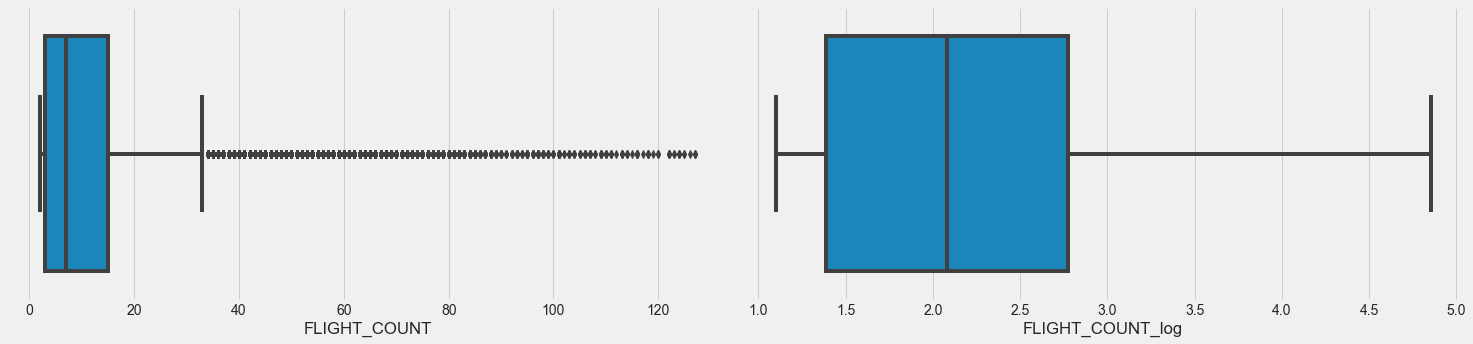

In [120]:
list_F = ['FLIGHT_COUNT', 'FLIGHT_COUNT_log']

plt.figure(figsize = (20.7, 5))

for i in range(0, len(list_F)):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(
        x = data_preprocess[list_F[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/FLIGHT_COUNT outlier boxplot.png', bbox_inches = 'tight')

### M: SEG_KM_SUM

#### Log Transformation using log1p

In [121]:
data_preprocess['SEG_KM_SUM_log'] = np.log1p(data_preprocess['SEG_KM_SUM'])
data_preprocess[['SEG_KM_SUM', 'SEG_KM_SUM_log']].describe()

SEG_KM_SUM  SEG_KM_SUM_log
count   62953.000000    62953.000000
mean    17028.112370        9.229144
std     20461.822823        1.017677
min       368.000000        5.910797
25%      4746.000000        8.465268
50%      9985.000000        9.208939
75%     21234.000000        9.963406
max    375074.000000       12.834881

In [122]:
data_preprocess[['SEG_KM_SUM', 'SEG_KM_SUM_log']].skew()

SEG_KM_SUM        3.483636
SEG_KM_SUM_log    0.098090
dtype: float64

#### Remove outlier

In [123]:
before_l = data_preprocess.shape[0]
before_l

62953

In [124]:
data_preprocess[['SEG_KM_SUM_log']].skew()

SEG_KM_SUM_log    0.09809
dtype: float64

In [125]:
Q1 = data_preprocess['SEG_KM_SUM_log'].quantile(0.25)
Q3 = data_preprocess['SEG_KM_SUM_log'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)

print(low_limit)
print(high_limit)

6.218061232257239
12.21061292904145


In [126]:
filtered_entries = ((data_preprocess['SEG_KM_SUM_log'] >= low_limit) & (data_preprocess['SEG_KM_SUM_log'] <= high_limit))
data_preprocess = data_preprocess[filtered_entries].reset_index(drop = True)
after_l = data_preprocess.shape[0]
after_l

62892

In [127]:
print('We removed', round((before_l - after_l)*100/before_l,2), '% of rows due to outlier.')

We removed 0.1 % of rows due to outlier.


In [128]:
data_preprocess[['SEG_KM_SUM', 'SEG_KM_SUM_log']].skew()

SEG_KM_SUM        2.877896
SEG_KM_SUM_log    0.096125
dtype: float64

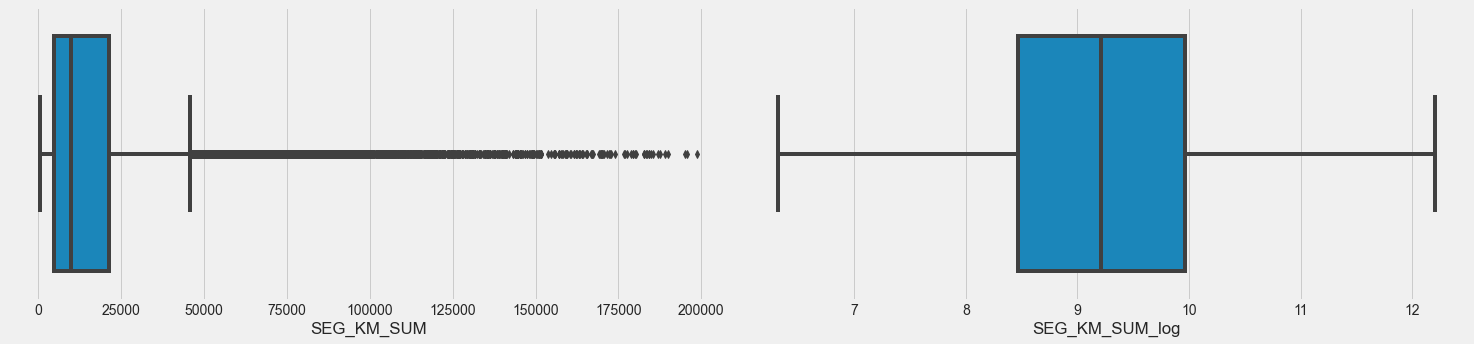

In [129]:
list_M = ['SEG_KM_SUM', 'SEG_KM_SUM_log']

plt.figure(figsize = (20.7, 5))

for i in range(0, len(list_M)):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(
        x = data_preprocess[list_M[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/SEG_KM_SUM outlier boxplot.png', bbox_inches = 'tight')

### C: avg_discount

#### Log Transformation using log1p

In [130]:
data_preprocess['avg_discount_log'] = np.log1p(data_preprocess['avg_discount'])
data_preprocess[['avg_discount', 'avg_discount_log']].describe()

avg_discount  avg_discount_log
count  62892.000000      62892.000000
mean       0.721370          0.537553
std        0.185403          0.104740
min        0.000000          0.000000
25%        0.611765          0.477330
50%        0.711684          0.537477
75%        0.809232          0.592903
max        1.500000          0.916291

In [131]:
data_preprocess[['avg_discount', 'avg_discount_log']].skew()

avg_discount        0.958021
avg_discount_log    0.384267
dtype: float64

#### Remove outlier

In [132]:
before_l = data_preprocess.shape[0]
before_l

62892

In [133]:
data_preprocess[['avg_discount_log']].skew()

avg_discount_log    0.384267
dtype: float64

In [134]:
Q1 = data_preprocess['avg_discount_log'].quantile(0.25)
Q3 = data_preprocess['avg_discount_log'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)

print(low_limit)
print(high_limit)

0.3039704326566968
0.7662620750888718


In [135]:
filtered_entries = ((data_preprocess['avg_discount_log'] >= low_limit) & (data_preprocess['avg_discount_log'] <= high_limit))
data_preprocess = data_preprocess[filtered_entries].reset_index(drop = True)
after_l = data_preprocess.shape[0]
after_l

60061

In [136]:
print('We removed', round((before_l - after_l)*100/before_l,2), '% of rows due to outlier.')

We removed 4.5 % of rows due to outlier.


In [137]:
data_preprocess[['avg_discount', 'avg_discount_log']].skew()

avg_discount        0.055341
avg_discount_log   -0.179520
dtype: float64

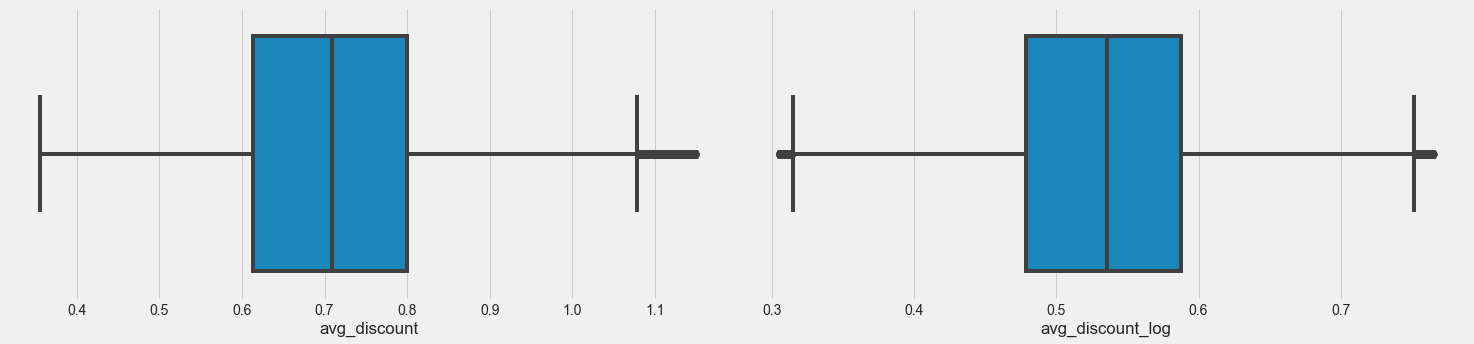

In [138]:
list_C = ['avg_discount', 'avg_discount_log']

plt.figure(figsize = (20.7, 5))

for i in range(0, len(list_C)):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(
        x = data_preprocess[list_C[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/avg_discount outlier boxplot.png', bbox_inches = 'tight')

### Re-Check Outlier

In [139]:
features_ready_log = [
    'MEMBERSHIP_MONTH_COUNT_log',
    'LAST_TO_END_log',
    'FLIGHT_COUNT_log',
    'SEG_KM_SUM_log',
    'avg_discount_log'
]

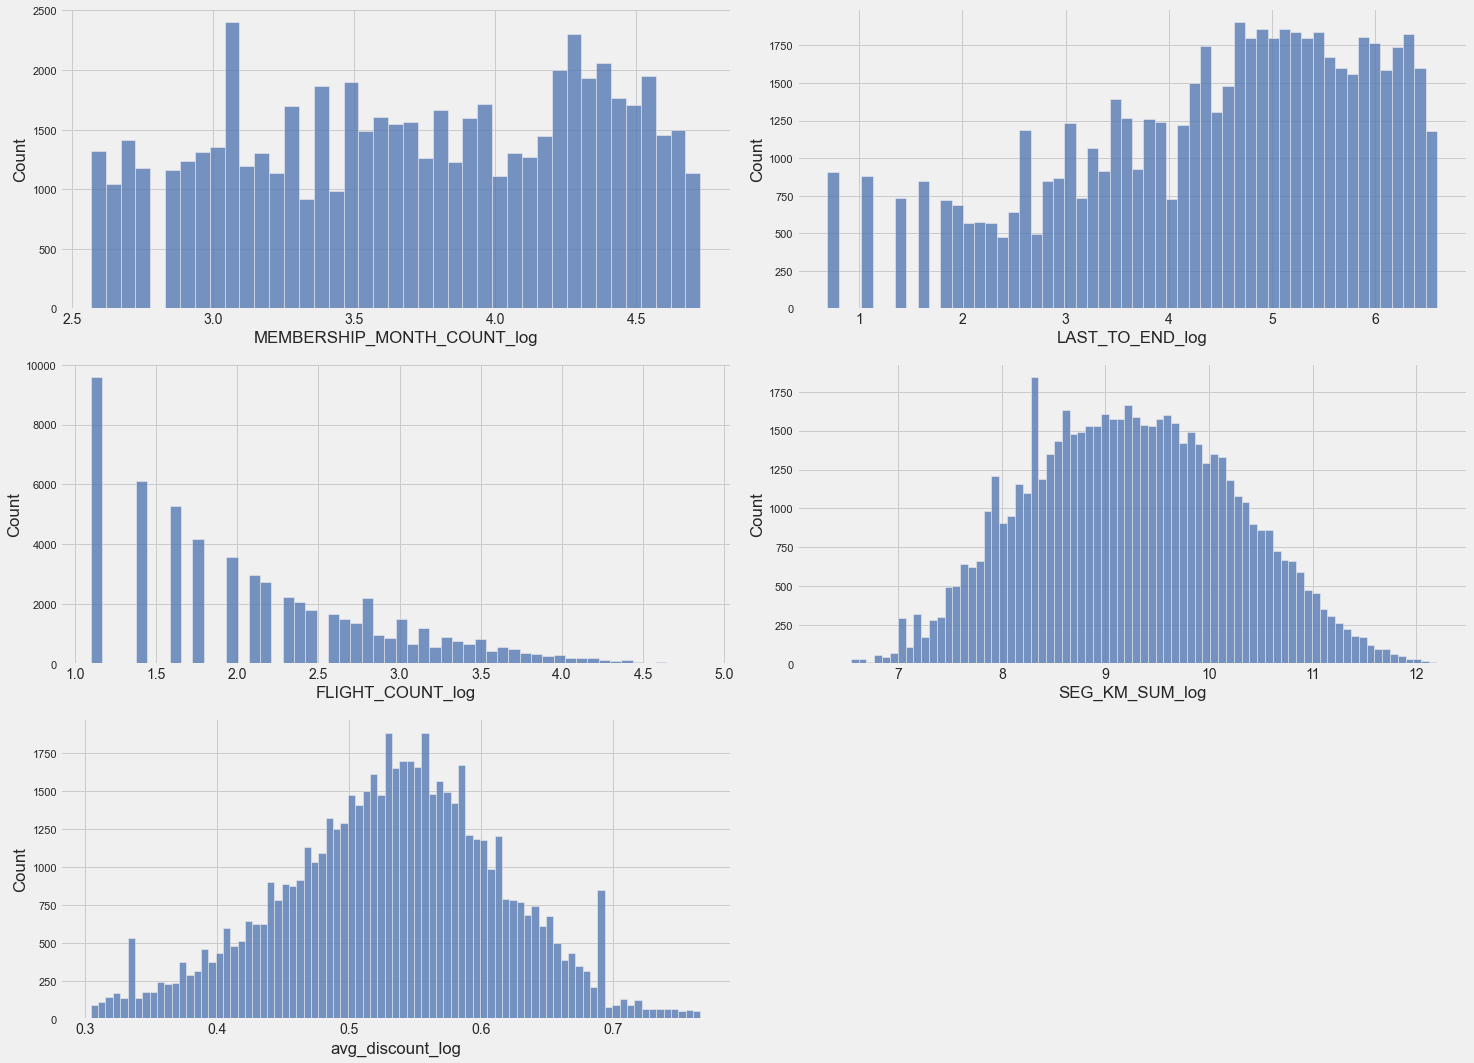

In [140]:
plt.figure(figsize = (20.7, 15))

for i in range(len(features_ready_log)):
    plt.subplot(3, 2, i + 1)
    sns.histplot(
        x = data_preprocess[features_ready_log[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/outlier-after histplot.png', bbox_inches = 'tight')

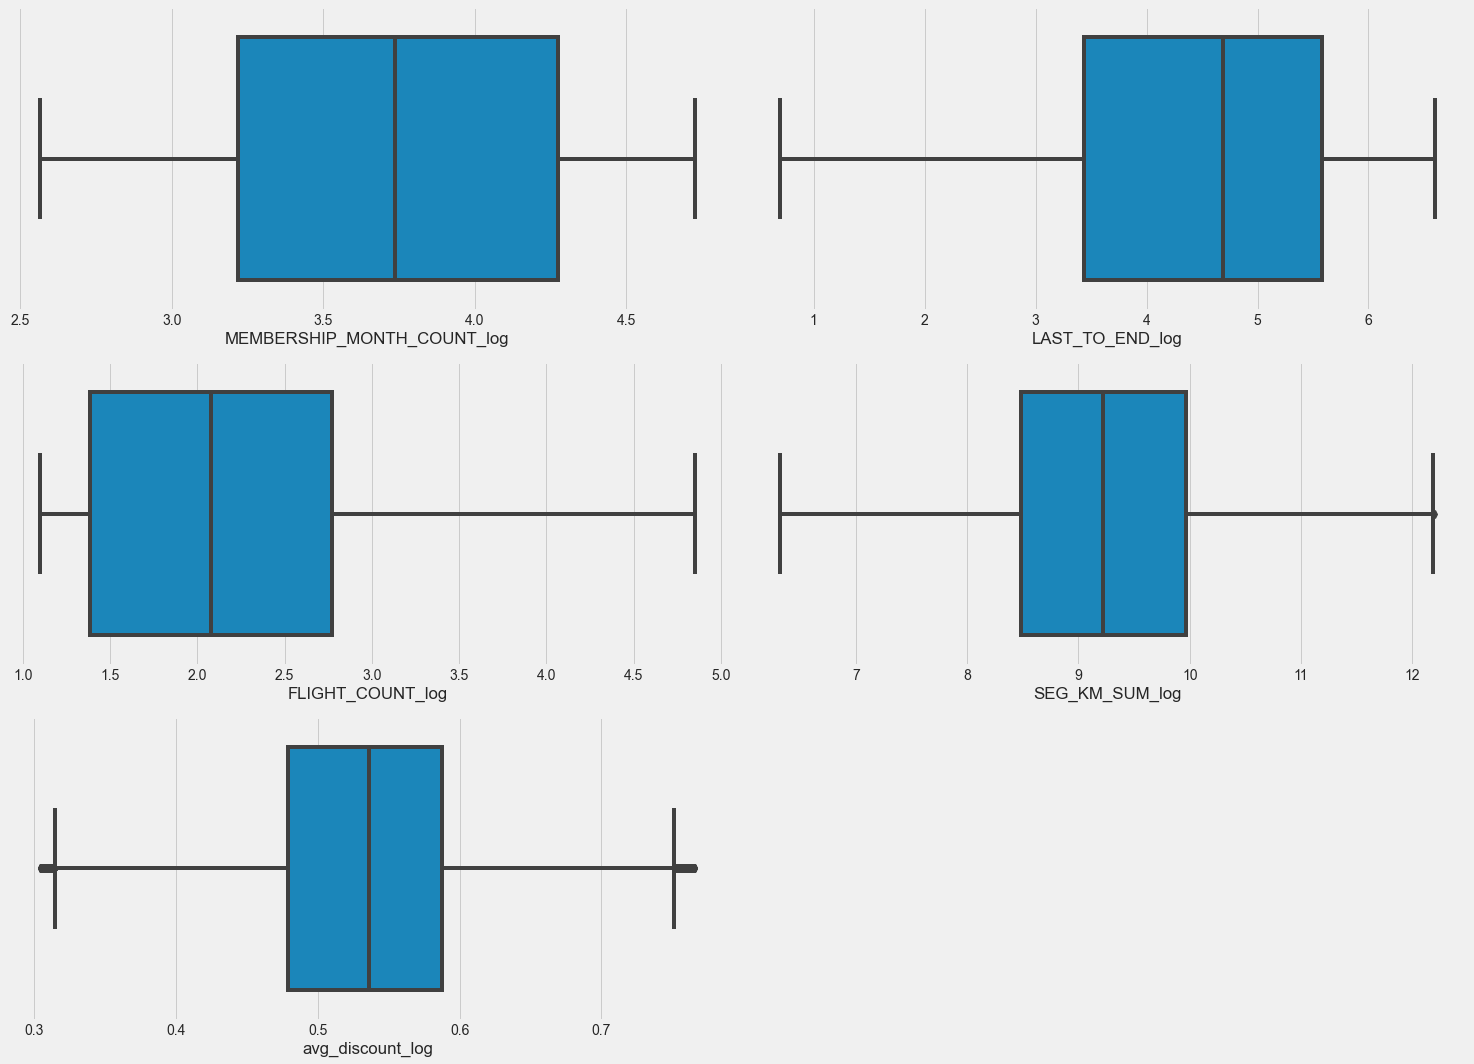

In [141]:
plt.figure(figsize = (20.7, 15))

for i in range(len(features_ready_log)):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(
        x = data_preprocess[features_ready_log[i]],
        data = data_preprocess
    )
    
    plt.xticks(fontsize = 14)
    
plt.tight_layout()

plt.savefig('fig/Pre-processing/outlier-after boxplot.png', bbox_inches = 'tight')

In [142]:
data_preprocess

MEMBER_NO    FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER  WORK_CITY  \
0          56149   2/13/2005          3/6/2005   Male         4      fanyu   
1          58693  12/11/2010          8/6/2011   Male         6      PARIS   
2          28780   7/13/2012         7/13/2012   Male         6  guangzhou   
3          38035  12/28/2004         5/11/2005   Male         6   shenzhen   
4          16812    6/9/2010         6/27/2010   Male         6    PUCHONG   
...          ...         ...               ...    ...       ...        ...   
60056      16431   1/17/2013         1/26/2013   Male         4    beijing   
60057       7579   5/25/2010         5/25/2010   Male         4  zhanjiang   
60058       7426   3/22/2013         3/22/2013   Male         4   dongying   
60059      10798  10/18/2012        11/11/2012   Male         4    shantou   
60060      50599  10/19/2011        10/19/2011   Male         4   shanghai   

              WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  Points_Sum  \
0                 guangdong           CN  39.0  3/31/2014  ...      239108   
1                       NaN           FR  39.0  3/31/2014  ...      237893   
2                 guangdong           CN  47.0  3/31/2014  ...      227957   
3            guangdongsheng           CN  42.0  3/31/2014  ...      177562   
4      Selangor Darul Ehsan           MY  52.0  3/31/2014  ...      204668   
...                     ...          ...   ...        ...  ...         ...   
60056                     .           CN  40.0  3/31/2014  ...         400   
60057             guangdong           CN  44.0  3/31/2014  ...         400   
60058              shandong           CN  49.0  3/31/2014  ...         200   
60059             guangdong           CN  70.0  3/31/2014  ...         400   
60060              shanghai           CN  35.0  3/31/2014  ...         400   

       Point_NotFlight  FFP_IN_DATE  LOAD_TIME_IN_DATE  \
0                   10   2005-02-13         2014-03-31   
1                    5   2010-12-11         2014-03-31   
2                   11   2012-07-13         2014-03-31   
3                    5   2004-12-28         2014-03-31   
4                    2   2010-06-09         2014-03-31   
...                ...          ...                ...   
60056                0   2013-01-17         2014-03-31   
60057                0   2010-05-25         2014-03-31   
60058                0   2013-03-22         2014-03-31   
60059                0   2012-10-18         2014-03-31   
60060                0   2011-10-19         2014-03-31   

       MEMBERSHIP_MONTH_COUNT MEMBERSHIP_MONTH_COUNT_log  LAST_TO_END_log  \
0                         109                   4.700480         3.555348   
1                          39                   3.688879         3.135494   
2                          20                   3.044522         0.693147   
3                         111                   4.718499         2.772589   
4                          45                   3.828641         1.945910   
...                       ...                        ...              ...   
60056                      14                   2.708050         5.998937   
60057                      46                   3.850148         6.161207   
60058                      12                   2.564949         5.924256   
60059                      17                   2.890372         6.212606   
60060                      29                   3.401197         6.270988   

       FLIGHT_COUNT_log  SEG_KM_SUM_log  avg_discount_log  
0              3.218876       12.153800          0.735833  
1              3.091042       12.130778          0.707793  
2              4.709530       12.142009          0.701105  
3              4.025352       11.943857          0.763606  
4              4.442651       12.137912          0.661673  
...                 ...             ...               ...  
60056          1.098612        6.616065          0.405465  
60057          1.098612        

## Standardization

In [143]:
dataset = data_preprocess.copy()

In [144]:
dataset

MEMBER_NO    FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER  WORK_CITY  \
0          56149   2/13/2005          3/6/2005   Male         4      fanyu   
1          58693  12/11/2010          8/6/2011   Male         6      PARIS   
2          28780   7/13/2012         7/13/2012   Male         6  guangzhou   
3          38035  12/28/2004         5/11/2005   Male         6   shenzhen   
4          16812    6/9/2010         6/27/2010   Male         6    PUCHONG   
...          ...         ...               ...    ...       ...        ...   
60056      16431   1/17/2013         1/26/2013   Male         4    beijing   
60057       7579   5/25/2010         5/25/2010   Male         4  zhanjiang   
60058       7426   3/22/2013         3/22/2013   Male         4   dongying   
60059      10798  10/18/2012        11/11/2012   Male         4    shantou   
60060      50599  10/19/2011        10/19/2011   Male         4   shanghai   

              WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  Points_Sum  \
0                 guangdong           CN  39.0  3/31/2014  ...      239108   
1                       NaN           FR  39.0  3/31/2014  ...      237893   
2                 guangdong           CN  47.0  3/31/2014  ...      227957   
3            guangdongsheng           CN  42.0  3/31/2014  ...      177562   
4      Selangor Darul Ehsan           MY  52.0  3/31/2014  ...      204668   
...                     ...          ...   ...        ...  ...         ...   
60056                     .           CN  40.0  3/31/2014  ...         400   
60057             guangdong           CN  44.0  3/31/2014  ...         400   
60058              shandong           CN  49.0  3/31/2014  ...         200   
60059             guangdong           CN  70.0  3/31/2014  ...         400   
60060              shanghai           CN  35.0  3/31/2014  ...         400   

       Point_NotFlight  FFP_IN_DATE  LOAD_TIME_IN_DATE  \
0                   10   2005-02-13         2014-03-31   
1                    5   2010-12-11         2014-03-31   
2                   11   2012-07-13         2014-03-31   
3                    5   2004-12-28         2014-03-31   
4                    2   2010-06-09         2014-03-31   
...                ...          ...                ...   
60056                0   2013-01-17         2014-03-31   
60057                0   2010-05-25         2014-03-31   
60058                0   2013-03-22         2014-03-31   
60059                0   2012-10-18         2014-03-31   
60060                0   2011-10-19         2014-03-31   

       MEMBERSHIP_MONTH_COUNT MEMBERSHIP_MONTH_COUNT_log  LAST_TO_END_log  \
0                         109                   4.700480         3.555348   
1                          39                   3.688879         3.135494   
2                          20                   3.044522         0.693147   
3                         111                   4.718499         2.772589   
4                          45                   3.828641         1.945910   
...                       ...                        ...              ...   
60056                      14                   2.708050         5.998937   
60057                      46                   3.850148         6.161207   
60058                      12                   2.564949         5.924256   
60059                      17                   2.890372         6.212606   
60060                      29                   3.401197         6.270988   

       FLIGHT_COUNT_log  SEG_KM_SUM_log  avg_discount_log  
0              3.218876       12.153800          0.735833  
1              3.091042       12.130778          0.707793  
2              4.709530       12.142009          0.701105  
3              4.025352       11.943857          0.763606  
4              4.442651       12.137912          0.661673  
...                 ...             ...               ...  
60056          1.098612        6.616065          0.405465  
60057          1.098612        

In [145]:
col_name = [
    'MEMBERSHIP_MONTH_COUNT_log',
    'LAST_TO_END_log',
    'FLIGHT_COUNT_log',
    'SEG_KM_SUM_log',
    'avg_discount_log'
]
col_name

['MEMBERSHIP_MONTH_COUNT_log',
 'LAST_TO_END_log',
 'FLIGHT_COUNT_log',
 'SEG_KM_SUM_log',
 'avg_discount_log']

In [146]:
dataset[col_name].head()

MEMBERSHIP_MONTH_COUNT_log  LAST_TO_END_log  FLIGHT_COUNT_log  \
0                    4.700480         3.555348          3.218876   
1                    3.688879         3.135494          3.091042   
2                    3.044522         0.693147          4.709530   
3                    4.718499         2.772589          4.025352   
4                    3.828641         1.945910          4.442651   

   SEG_KM_SUM_log  avg_discount_log  
0       12.153800          0.735833  
1       12.130778          0.707793  
2       12.142009          0.701105  
3       11.943857          0.763606  
4       12.137912          0.661673

In [147]:
std_scaler = StandardScaler()

X = std_scaler.fit_transform(dataset[col_name].astype(float))

In [148]:
X

array([[ 1.60420085, -0.58805932,  1.27488379,  2.9011387 ,  2.41667296],
       [-0.05172679, -0.87534833,  1.11967569,  2.87825466,  2.08446767],
       [-1.10649906, -2.54654767,  3.08475261,  2.88941817,  2.00522448],
       ...,
       [-1.8915303 ,  1.03288848, -1.29942109, -2.60338479, -2.10509439],
       [-1.35883412,  1.23019493, -1.29942109, -2.58492798, -2.31479178],
       [-0.52264441,  1.2701436 , -1.29942109, -2.62762996, -2.31479178]])

# Modeling

## Find the Best K

In [149]:
arr_inertia = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, random_state = 0)
    kmeans.fit(X)
    arr_inertia.append(kmeans.inertia_)

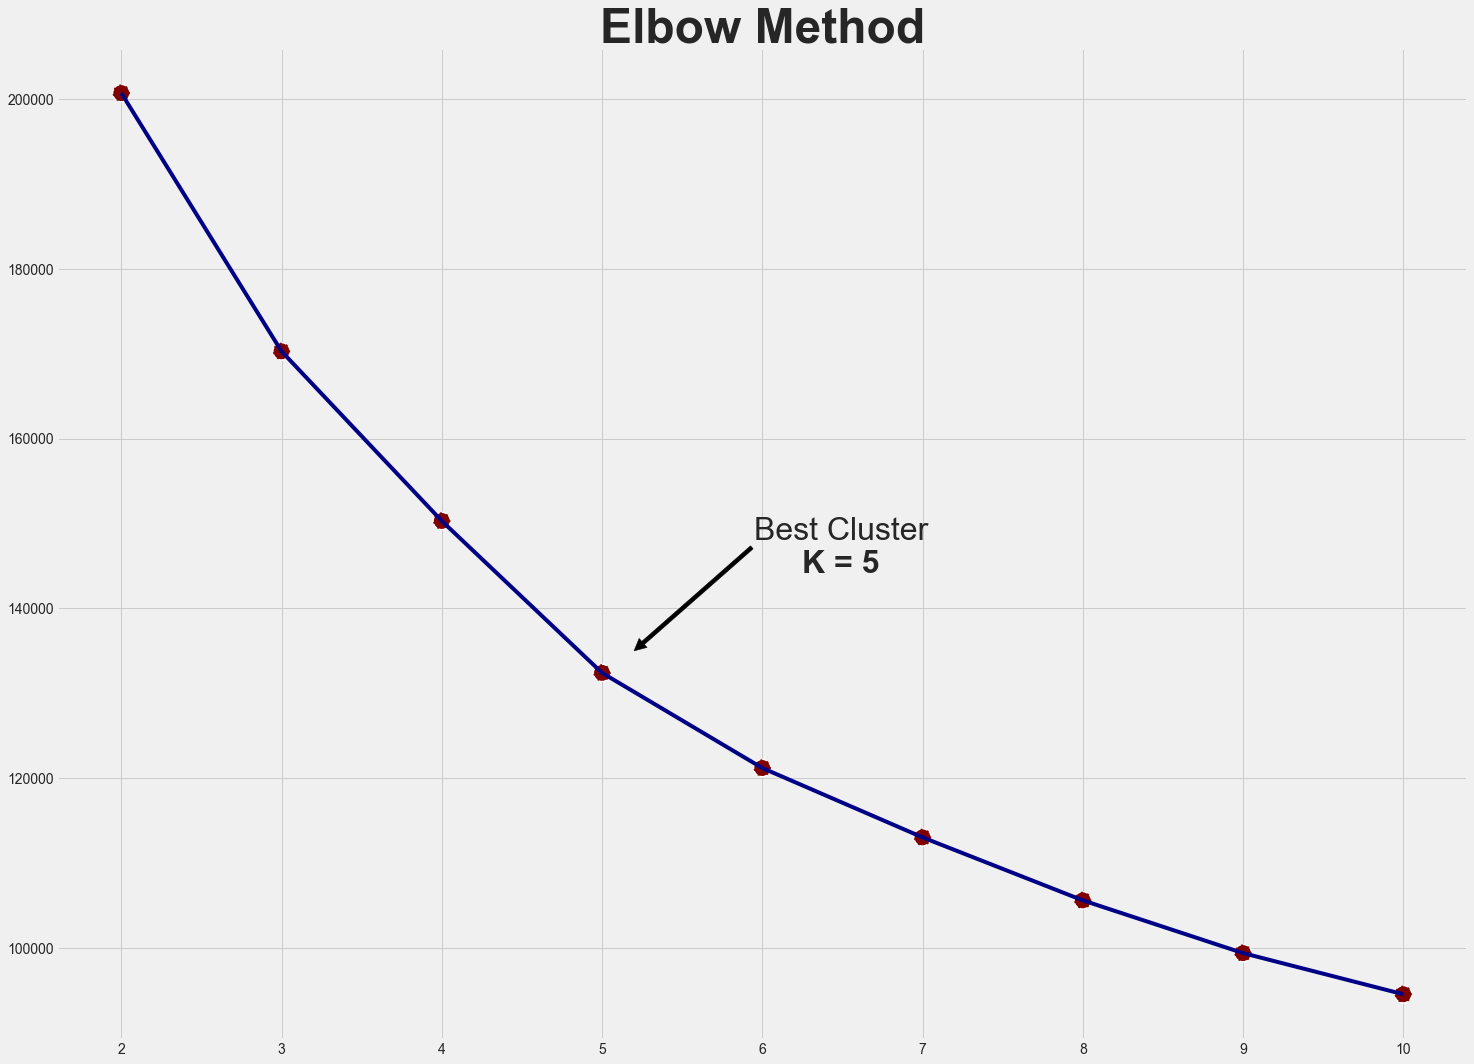

In [150]:
fig, ax = plt.subplots(figsize = (20.7, 15))
sns.lineplot(
    x = range(2, 11),
    y = arr_inertia,
    color = '#000087',
    linewidth = 4
)

sns.scatterplot(
    x = range(2, 11),
    y = arr_inertia,
    s = 300,
    color = '#800000',
    linestyle = '--',
    ax = ax
)

ax.annotate(
    text = 'Best Cluster', xy = (5.2, 135000), xycoords = 'data', fontsize = 32, xytext = (120, 120),
    textcoords = 'offset points', arrowprops = dict(color = 'black'),
    horizontalalignment = 'left', verticalalignment = 'center'
)

ax.annotate(
    text = 'K = 5', xy = (5.5, 130000), xycoords = 'data', fontsize = 32, fontweight = 'bold',
    xytext = (120, 120), textcoords = 'offset points',
)

plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)

plt.title('Elbow Method', fontsize = 48, fontweight = 'bold')

plt.tight_layout()

plt.savefig('fig/Modeling/elbow method line-scatterplot.png', bbox_inches = 'tight')

In [151]:
# range_n_clusters = list(range(2, 11))
# print(range_n_clusters)

In [152]:
# arr_silhouette_score_euclidean = []

# for i in range_n_clusters:
#     kmeans = KMeans(n_clusters = i).fit(X)
#     preds = kmeans.predict(X)
    
#     score_euclidean = silhouette_score(X, preds, metric = 'euclidean')
#     arr_silhouette_score_euclidean.append(score_euclidean)

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [153]:
# fig, ax = plt.subplots(figsize = (20.7, 10))
# sns.lineplot(
#     x = range(2, 11),
#     y = arr_silhouette_score_euclidean,
# #     color = '#000087',
#     linewidth = 4
# )

# sns.scatterplot(
#     x = range(2, 11),
#     y = arr_silhouette_score_euclidean,
#     s = 300,
#     color = '#800000',
#     linestyle = '--',
#     ax = ax
# )

# plt.yticks(fontsize = 14)
# plt.xticks(fontsize = 14)

# plt.title('Euclidean Silhouette Score', fontsize = 48, fontweight = 'bold')

# plt.tight_layout()

# plt.savefig('fig/Modeling/euclidean line-scatterplot.png', bbox_inches = 'tight')

## Clustering

In [154]:
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(X)

In [155]:
cluster = kmeans.labels_

In [156]:
dataset.loc[:, 'cluster'] = cluster

In [157]:
dataset['cluster'].value_counts()

4    13608
0    12637
1    12091
2    11131
3    10594
Name: cluster, dtype: int64

In [158]:
dataset[[
    'MEMBERSHIP_MONTH_COUNT_log', 'LAST_TO_END_log', 'FLIGHT_COUNT_log', 'SEG_KM_SUM_log', 'avg_discount_log', 'cluster'
]].head()

MEMBERSHIP_MONTH_COUNT_log  LAST_TO_END_log  FLIGHT_COUNT_log  \
0                    4.700480         3.555348          3.218876   
1                    3.688879         3.135494          3.091042   
2                    3.044522         0.693147          4.709530   
3                    4.718499         2.772589          4.025352   
4                    3.828641         1.945910          4.442651   

   SEG_KM_SUM_log  avg_discount_log  cluster  
0       12.153800          0.735833        2  
1       12.130778          0.707793        2  
2       12.142009          0.701105        2  
3       11.943857          0.763606        2  
4       12.137912          0.661673        2

In [159]:
dataset.groupby(['cluster']).mean()[[
    'MEMBERSHIP_MONTH_COUNT_log', 'LAST_TO_END_log', 'FLIGHT_COUNT_log', 'SEG_KM_SUM_log', 'avg_discount_log'
]]

MEMBERSHIP_MONTH_COUNT_log  LAST_TO_END_log  FLIGHT_COUNT_log  \
cluster                                                                  
0                          3.604527         5.526566          1.422627   
1                          3.137798         3.959551          2.445979   
2                          4.067077         2.700915          3.374444   
3                          3.456471         5.317084          1.445975   
4                          4.267908         4.486152          2.192207   

         SEG_KM_SUM_log  avg_discount_log  
cluster                                    
0              8.224417          0.606546  
1              9.638299          0.533897  
2             10.557417          0.552693  
3              8.441336          0.424961  
4              9.352001          0.526844

# Visualization

In [160]:
dataset.head()

MEMBER_NO    FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER  WORK_CITY  \
0      56149   2/13/2005          3/6/2005   Male         4      fanyu   
1      58693  12/11/2010          8/6/2011   Male         6      PARIS   
2      28780   7/13/2012         7/13/2012   Male         6  guangzhou   
3      38035  12/28/2004         5/11/2005   Male         6   shenzhen   
4      16812    6/9/2010         6/27/2010   Male         6    PUCHONG   

          WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  Point_NotFlight  \
0             guangdong           CN  39.0  3/31/2014  ...               10   
1                   NaN           FR  39.0  3/31/2014  ...                5   
2             guangdong           CN  47.0  3/31/2014  ...               11   
3        guangdongsheng           CN  42.0  3/31/2014  ...                5   
4  Selangor Darul Ehsan           MY  52.0  3/31/2014  ...                2   

   FFP_IN_DATE  LOAD_TIME_IN_DATE  MEMBERSHIP_MONTH_COUNT  \
0   2005-02-13         2014-03-31                     109   
1   2010-12-11         2014-03-31                      39   
2   2012-07-13         2014-03-31                      20   
3   2004-12-28         2014-03-31                     111   
4   2010-06-09         2014-03-31                      45   

   MEMBERSHIP_MONTH_COUNT_log LAST_TO_END_log  FLIGHT_COUNT_log  \
0                    4.700480        3.555348          3.218876   
1                    3.688879        3.135494          3.091042   
2                    3.044522        0.693147          4.709530   
3                    4.718499        2.772589          4.025352   
4                    3.828641        1.945910          4.442651   

   SEG_KM_SUM_log  avg_discount_log  cluster  
0       12.153800          0.735833        2  
1       12.130778          0.707793        2  
2       12.142009          0.701105        2  
3       11.943857          0.763606        2  
4       12.137912          0.661673        2  

[5 rows x 32 columns]

In [161]:
data_std = std_scaler.fit_transform(dataset[col_name].astype(float))

In [162]:
data_std

array([[ 1.60420085, -0.58805932,  1.27488379,  2.9011387 ,  2.41667296],
       [-0.05172679, -0.87534833,  1.11967569,  2.87825466,  2.08446767],
       [-1.10649906, -2.54654767,  3.08475261,  2.88941817,  2.00522448],
       ...,
       [-1.8915303 ,  1.03288848, -1.29942109, -2.60338479, -2.10509439],
       [-1.35883412,  1.23019493, -1.29942109, -2.58492798, -2.31479178],
       [-0.52264441,  1.2701436 , -1.29942109, -2.62762996, -2.31479178]])

## Dimensionality Reduction using PCA

In [163]:
pca = PCA(n_components = 2)
pca.fit(data_std)

pcs = pca.transform(data_std)
pcs

array([[ 3.28777496,  2.3840861 ],
       [ 2.96649282,  1.28198752],
       [ 4.76567216,  0.3793695 ],
       ...,
       [-3.3743228 , -2.20845901],
       [-3.37170988, -2.10866825],
       [-3.2517142 , -1.70547756]])

In [164]:
data_pca = pd.DataFrame(data = pcs, columns = ['PCA 1', 'PCA 2'])
data_pca['cluster'] = cluster

data_pca

PCA 1     PCA 2  cluster
0      3.287775  2.384086        2
1      2.966493  1.281988        2
2      4.765672  0.379370        2
3      4.052662  2.583502        2
4      4.363826  0.731119        2
...         ...       ...      ...
60056 -3.303284 -1.567230        3
60057 -2.990755 -1.387679        3
60058 -3.374323 -2.208459        3
60059 -3.371710 -2.108668        3
60060 -3.251714 -1.705478        3

[60061 rows x 3 columns]

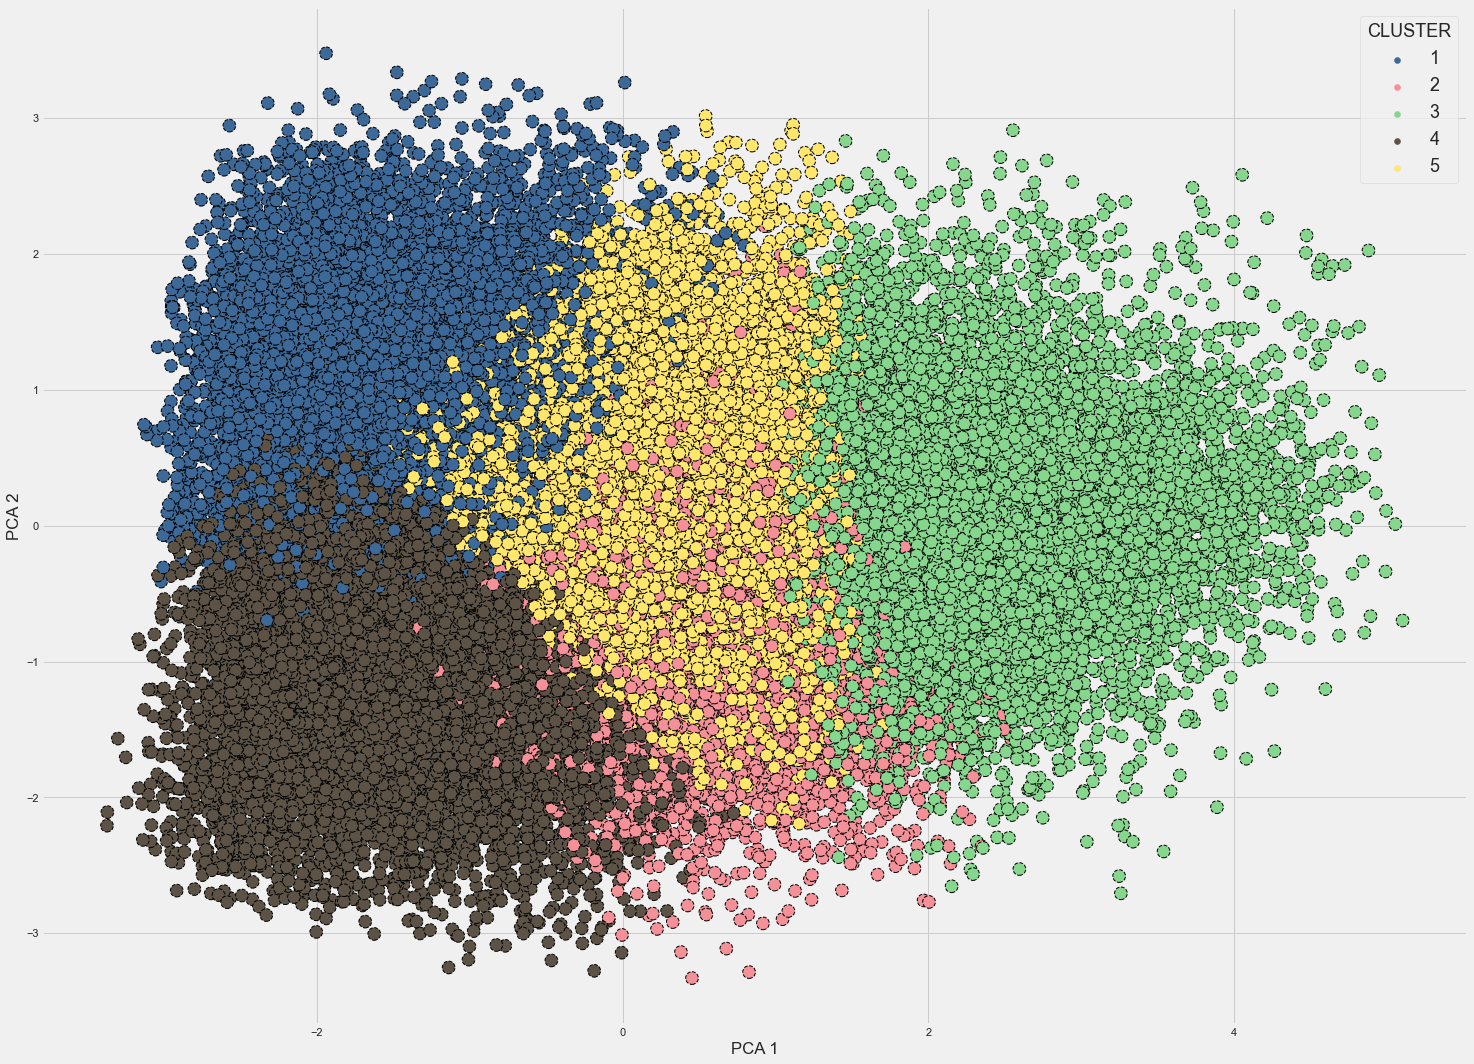

In [165]:
plt.figure(figsize = (20.7, 15))

ax = sns.scatterplot(
    x = 'PCA 1',
    y = 'PCA 2',
    hue = 'cluster',
    edgecolor = 'black',
    linestyle = '--',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    s = 160,
    data = data_pca
)

L = plt.legend(fontsize = 18)
L.get_texts()[0].set_text('1')
L.get_texts()[1].set_text('2')
L.get_texts()[2].set_text('3')
L.get_texts()[3].set_text('4')
L.get_texts()[4].set_text('5')
L.set_title('CLUSTER', prop = {'size' : 18})

plt.tight_layout()

# ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d']

plt.savefig('fig/Insight/Cluster-scatterplot.png', bbox_inches = 'tight')

# Insight

## Re-transform

In [166]:
features_cluster = [
    'MEMBERSHIP_MONTH_COUNT_log', 'LAST_TO_END_log', 'FLIGHT_COUNT_log', 'SEG_KM_SUM_log', 'avg_discount_log', 'cluster'
]

In [167]:
dataset[features_cluster].head()

MEMBERSHIP_MONTH_COUNT_log  LAST_TO_END_log  FLIGHT_COUNT_log  \
0                    4.700480         3.555348          3.218876   
1                    3.688879         3.135494          3.091042   
2                    3.044522         0.693147          4.709530   
3                    4.718499         2.772589          4.025352   
4                    3.828641         1.945910          4.442651   

   SEG_KM_SUM_log  avg_discount_log  cluster  
0       12.153800          0.735833        2  
1       12.130778          0.707793        2  
2       12.142009          0.701105        2  
3       11.943857          0.763606        2  
4       12.137912          0.661673        2

In [168]:
dataset['MEMBERSHIP_MONTH_COUNT_exp'] = np.expm1(dataset['MEMBERSHIP_MONTH_COUNT_log'])
dataset['LAST_TO_END_exp'] = np.expm1(dataset['LAST_TO_END_log'])
dataset['FLIGHT_COUNT_exp'] = np.expm1(dataset['FLIGHT_COUNT_log'])
dataset['SEG_KM_SUM_exp'] = np.expm1(dataset['SEG_KM_SUM_log'])
dataset['avg_discount_exp'] = np.expm1(dataset['avg_discount_log'])

In [169]:
features_cluster_retransformed = [
    'MEMBERSHIP_MONTH_COUNT_exp', 'LAST_TO_END_exp', 'FLIGHT_COUNT_exp', 'SEG_KM_SUM_exp', 'avg_discount_exp', 'cluster'
]

In [170]:
dataset[features_cluster_retransformed]

MEMBERSHIP_MONTH_COUNT_exp  LAST_TO_END_exp  FLIGHT_COUNT_exp  \
0                           109.0             34.0              24.0   
1                            39.0             22.0              21.0   
2                            20.0              1.0             110.0   
3                           111.0             15.0              55.0   
4                            45.0              6.0              84.0   
...                           ...              ...               ...   
60056                        14.0            402.0               2.0   
60057                        46.0            473.0               2.0   
60058                        12.0            373.0               2.0   
60059                        17.0            498.0               2.0   
60060                        29.0            528.0               2.0   

       SEG_KM_SUM_exp  avg_discount_exp  cluster  
0            189813.0          1.087220        2  
1            185493.0          1.029508        2  
2            187588.0          1.015978        2  
3            153868.0          1.146001        2  
4            186821.0          0.938031        2  
...               ...               ...      ...  
60056           746.0          0.500000        3  
60057           834.0          0.400000        3  
60058           746.0          0.425000        3  
60059           760.0          0.400000        3  
60060           728.0          0.400000        3  

[60061 rows x 6 columns]

## MEMBERSHIP_MONTH_COUNT

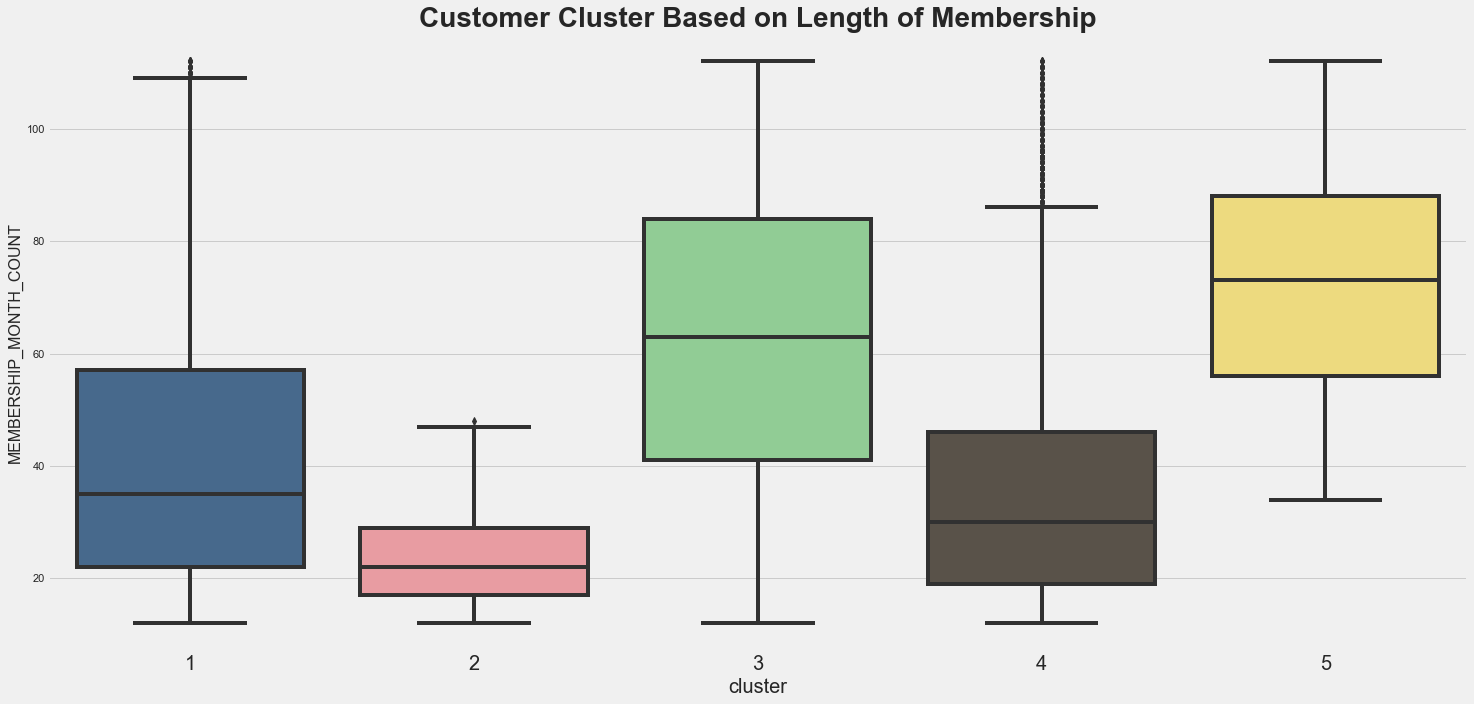

In [171]:
plt.figure(figsize = (20.7, 10))
   
sns.boxplot(
    x = 'cluster',
    y = 'MEMBERSHIP_MONTH_COUNT_exp',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    data = dataset
)

plt.xlabel('cluster', fontsize = 20)
plt.ylabel('MEMBERSHIP_MONTH_COUNT', fontsize = 16)

plt.xticks(np.arange(5), ('1', '2', '3', '4', '5'), fontsize = 20)

plt.title('Customer Cluster Based on Length of Membership', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight membership_month_count.png', bbox_inches = 'tight')

## LAST_TO_END

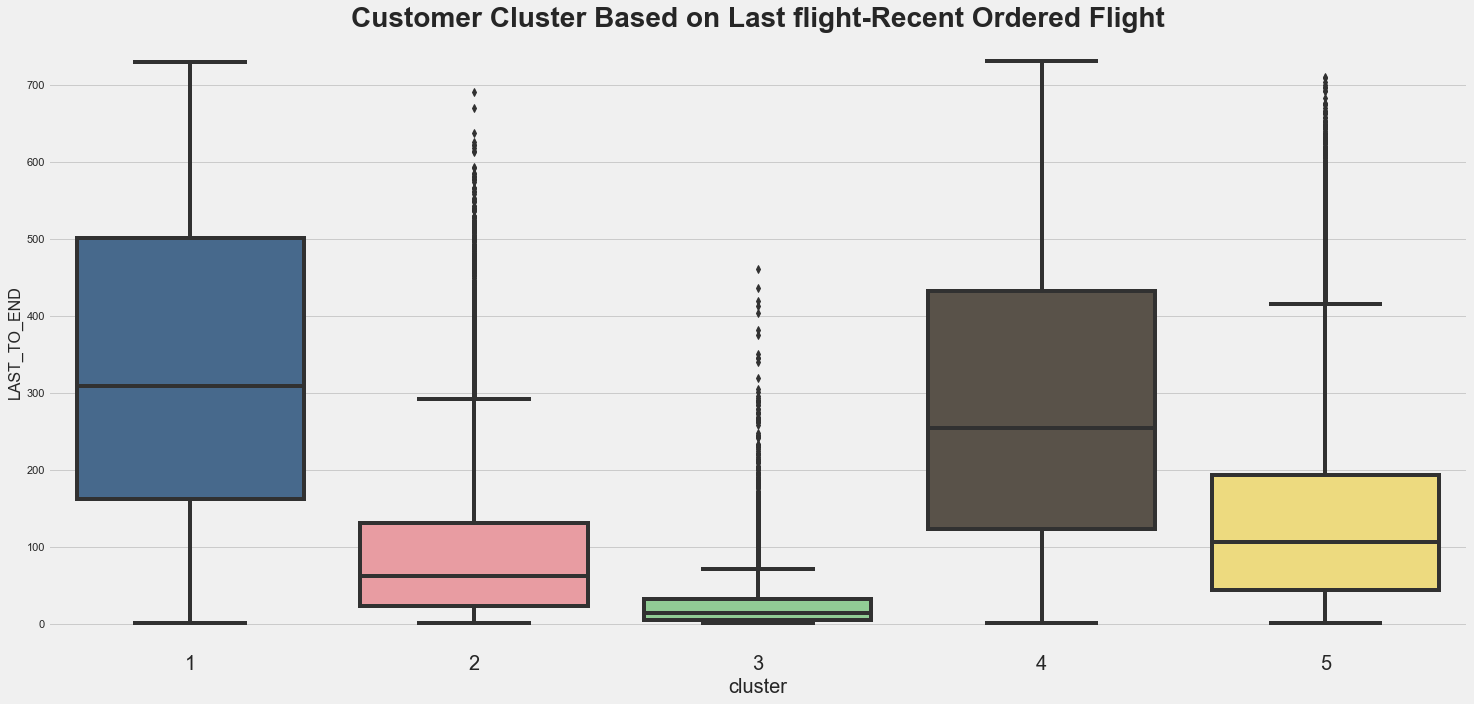

In [172]:
plt.figure(figsize = (20.7, 10))
    
sns.boxplot(
    x = 'cluster',
    y = 'LAST_TO_END_exp',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    data = dataset
)

plt.xlabel('cluster', fontsize = 20)
plt.ylabel('LAST_TO_END', fontsize = 16)

plt.xticks(np.arange(5), ('1', '2', '3', '4', '5'), fontsize = 20)

plt.title('Customer Cluster Based on Last flight-Recent Ordered Flight', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight last_to_end.png', bbox_inches = 'tight')

## FLIGHT_COUNT

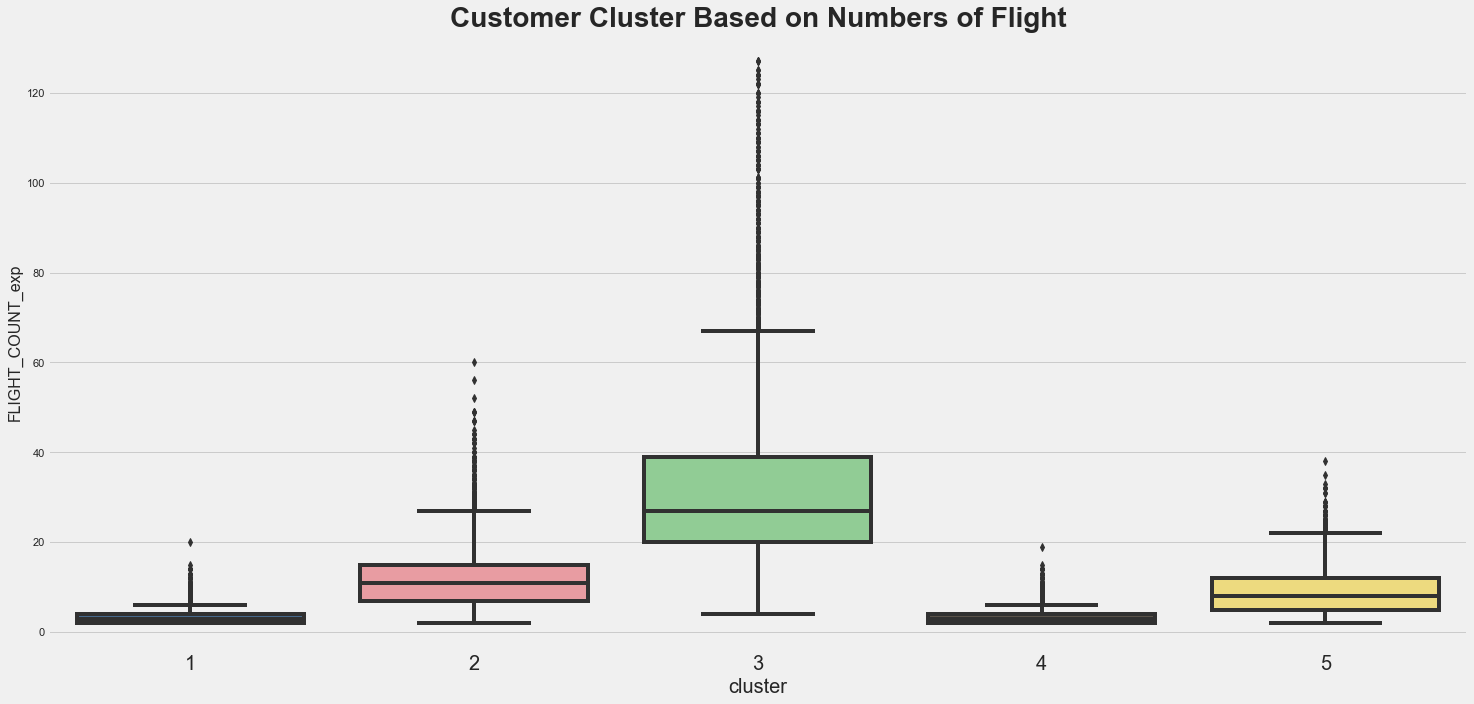

In [173]:
plt.figure(figsize = (20.7, 10))
    
sns.boxplot(
    x = 'cluster',
    y = 'FLIGHT_COUNT_exp',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    data = dataset
)

plt.xlabel('cluster', fontsize = 20)
plt.ylabel('FLIGHT_COUNT_exp', fontsize = 16)

plt.xticks(np.arange(5), ('1', '2', '3', '4', '5'), fontsize = 20)

plt.title('Customer Cluster Based on Numbers of Flight', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight flight_count.png', bbox_inches = 'tight')

## SEG_KM_SUM

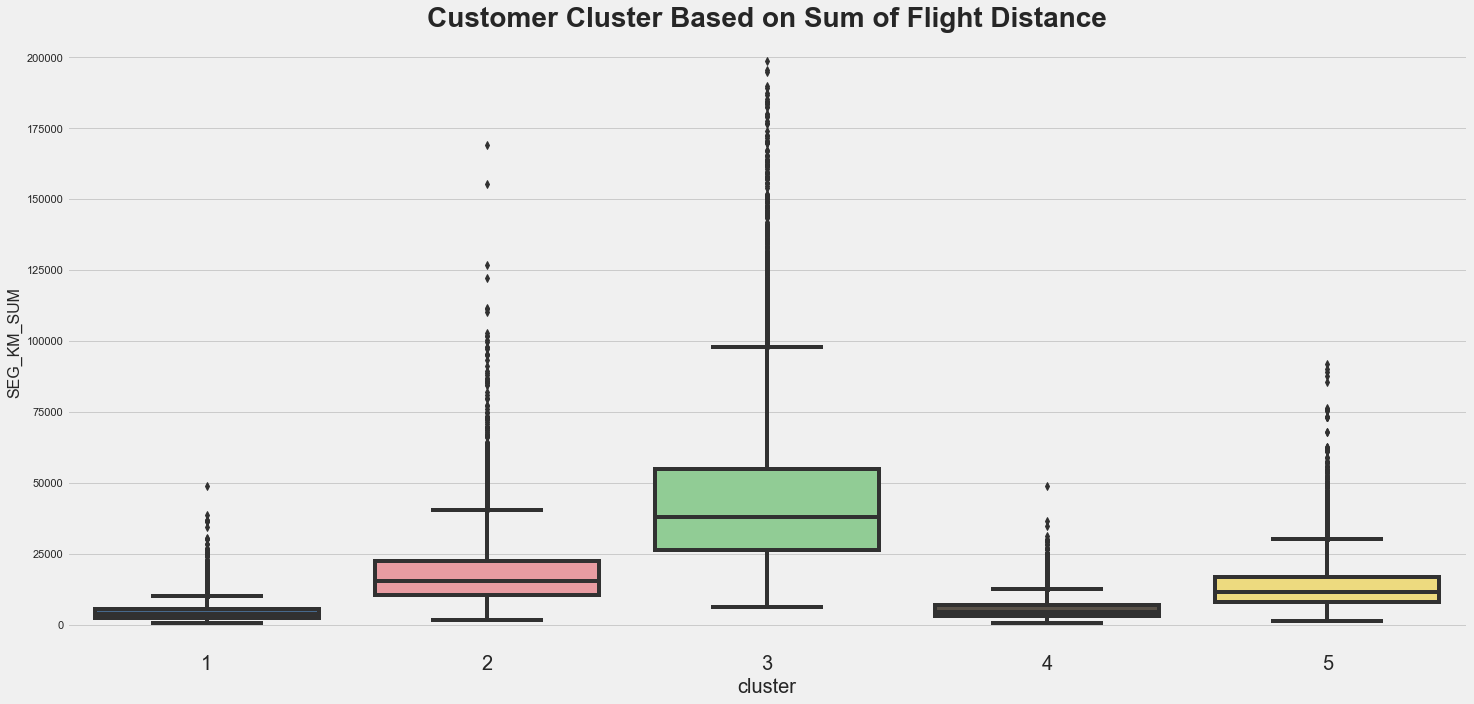

In [174]:
plt.figure(figsize = (20.7, 10))
   
sns.boxplot(
    x = 'cluster',
    y = 'SEG_KM_SUM_exp',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    data = dataset
)

plt.xlabel('cluster', fontsize = 20)
plt.ylabel('SEG_KM_SUM', fontsize = 16)

plt.xticks(np.arange(5), ('1', '2', '3', '4', '5'), fontsize = 20)

plt.title('Customer Cluster Based on Sum of Flight Distance', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight seg_km_sum.png', bbox_inches = 'tight')

## avg_discount

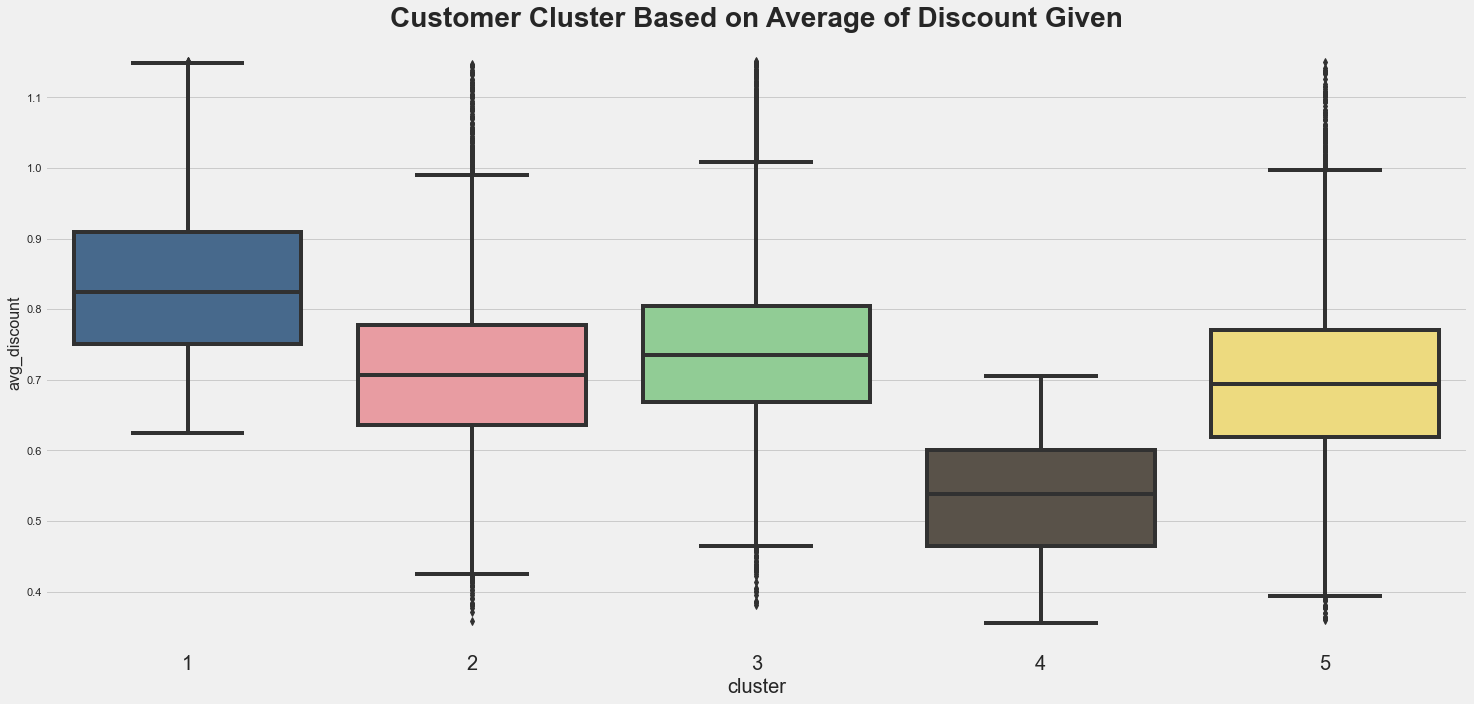

In [175]:
plt.figure(figsize = (20.7, 10))
    
sns.boxplot(
    x = 'cluster',
    y = 'avg_discount_exp',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    data = dataset
)

plt.xlabel('cluster', fontsize = 20)
plt.ylabel('avg_discount', fontsize = 16)

plt.xticks(np.arange(5), ('1', '2', '3', '4', '5'), fontsize = 20)

plt.title('Customer Cluster Based on Average of Discount Given', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight avg_discount_exp.png', bbox_inches = 'tight')

## PROVINCE IN CHINA

In [176]:
join_dataset = dataset.merge(
    data_copy,
    on = 'MEMBER_NO',
    how = 'inner'
)
print(join_dataset.shape)
join_dataset.head()

(60061, 74)


MEMBER_NO  FFP_DATE_x FIRST_FLIGHT_DATE_x GENDER_x  FFP_TIER_x WORK_CITY_x  \
0      56149   2/13/2005            3/6/2005     Male           4       fanyu   
1      58693  12/11/2010            8/6/2011     Male           6       PARIS   
2      28780   7/13/2012           7/13/2012     Male           6   guangzhou   
3      38035  12/28/2004           5/11/2005     Male           6    shenzhen   
4      16812    6/9/2010           6/27/2010     Male           6     PUCHONG   

        WORK_PROVINCE_x WORK_COUNTRY_x  AGE_x LOAD_TIME_x  ...  fflight_year  \
0             guangdong             CN   39.0   3/31/2014  ...          2005   
1                   NaN             FR   39.0   3/31/2014  ...          2011   
2             guangdong             CN   47.0   3/31/2014  ...          2012   
3        guangdongsheng             CN   42.0   3/31/2014  ...          2005   
4  Selangor Darul Ehsan             MY   52.0   3/31/2014  ...          2010   

   fflight_month  fflight_month_name  LAST_FLIGHT_IN_DATE  lflight_year  \
0              3               March           2014-02-27          2014   
1              8              August           2014-03-10          2014   
2              7                July           2014-03-31          2014   
3              5                 May           2014-03-17          2014   
4              6                June           2014-03-26          2014   

  lflight_month  lflight_month_name  WORK_CITY_GROUP  WORK_PROVINCE_GROUP  \
0             2            February           others            guangdong   
1             3               March           others               others   
2             3               March        guangzhou            guangdong   
3             3               March         shenzhen               others   
4             3               March           others               others   

   WORK_COUNTRY_GROUP  
0                  CN  
1              others  
2                  CN  
3                  CN  
4                  MY  

[5 rows x 74 columns]

In [177]:
cn = join_dataset[join_dataset['WORK_COUNTRY_GROUP'] == 'CN']
cn.head()[['WORK_COUNTRY_GROUP']]

WORK_COUNTRY_GROUP
0                 CN
2                 CN
3                 CN
5                 CN
7                 CN

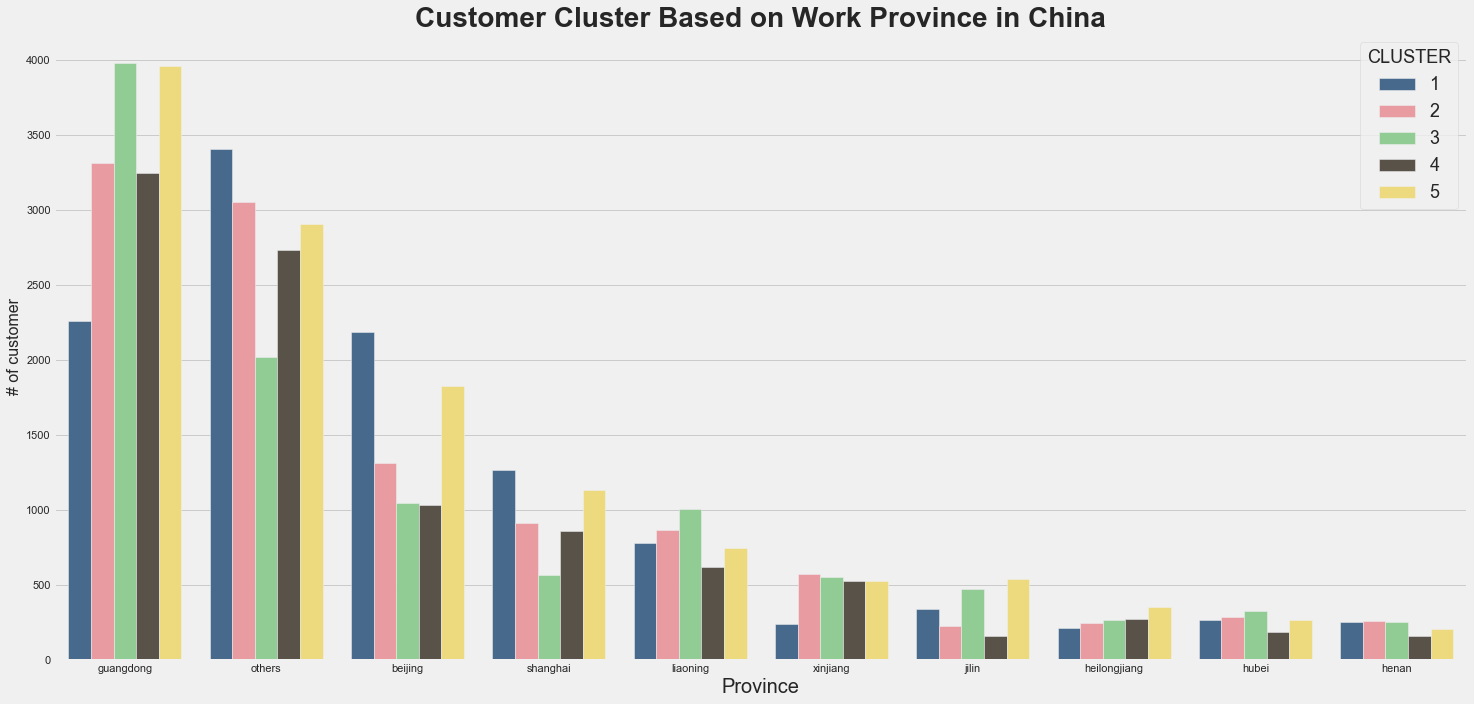

In [178]:
plt.figure(figsize = (20.7, 10))
# plot proportion    
sns.countplot(
    x = 'WORK_PROVINCE_GROUP',
    hue = 'cluster',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    order = cn['WORK_PROVINCE_GROUP'].value_counts().index,
    data = join_dataset[join_dataset['WORK_COUNTRY_GROUP'] == 'CN']
)

L = plt.legend(fontsize = 18)
L.get_texts()[0].set_text('1')
L.get_texts()[1].set_text('2')
L.get_texts()[2].set_text('3')
L.get_texts()[3].set_text('4')
L.get_texts()[4].set_text('5')
L.set_title('CLUSTER', prop = {'size' : 18})

plt.xlabel('Province', fontsize = 20)
plt.ylabel('# of customer', fontsize = 16)

plt.title('Customer Cluster Based on Work Province in China', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight province in china.png', bbox_inches = 'tight')

## AGE

In [179]:
join_dataset['AGE_x'].describe()

count    59673.000000
mean        42.296550
std          9.764581
min          6.000000
25%         35.000000
50%         41.000000
75%         48.000000
max        110.000000
Name: AGE_x, dtype: float64

In [180]:
def group_age(x):
    age = 'Unknown'
    if x['AGE_x'] <= 20:
        age = '< 21'
    elif x['AGE_x'] > 20 and x['AGE_x'] <= 40:
        age = '21-40'
    elif x['AGE_x'] > 40 and x['AGE_x'] <= 60:
        age = '41-60'
    elif x['AGE_x'] > 60 and x['AGE_x'] <= 80:
        age = '61-80'
    elif x['AGE_x'] > 80:
        age = '> 80'
    return age

In [181]:
join_dataset['AGE_Group'] = join_dataset.apply(lambda x: group_age(x), axis = 1)

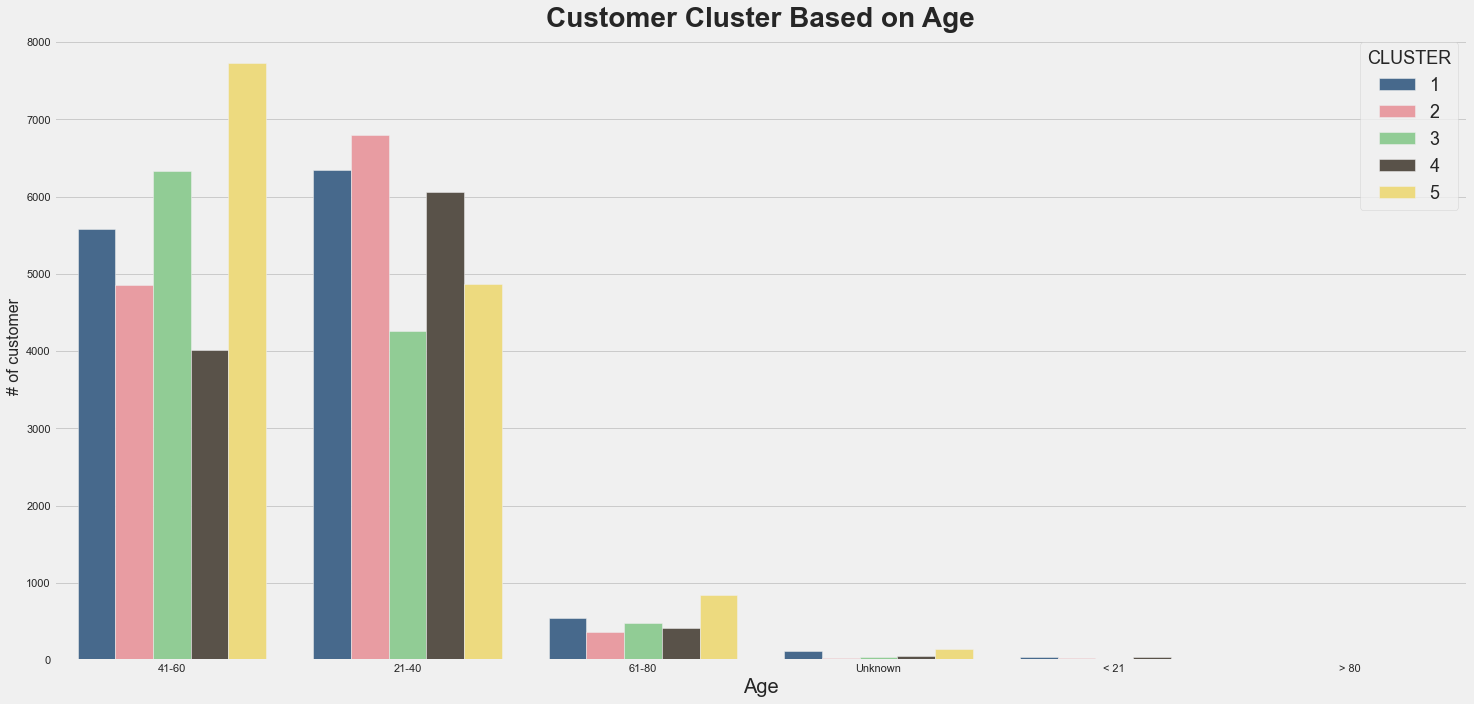

In [182]:
plt.figure(figsize = (20.7, 10))
# plot proportion    
sns.countplot(
    x = 'AGE_Group',
    hue = 'cluster',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    order = join_dataset['AGE_Group'].value_counts().index,
    data = join_dataset
)

L = plt.legend(fontsize = 18)
L.get_texts()[0].set_text('1')
L.get_texts()[1].set_text('2')
L.get_texts()[2].set_text('3')
L.get_texts()[3].set_text('4')
L.get_texts()[4].set_text('5')
L.set_title('CLUSTER', prop = {'size' : 18})

plt.xlabel('Age', fontsize = 20)
plt.ylabel('# of customer', fontsize = 16)

plt.title('Customer Cluster Based on Age', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight age.png', bbox_inches = 'tight')

## GENDER

In [183]:
join_dataset['GENDER_x'].value_counts()

Male      45867
Female    14192
Name: GENDER_x, dtype: int64

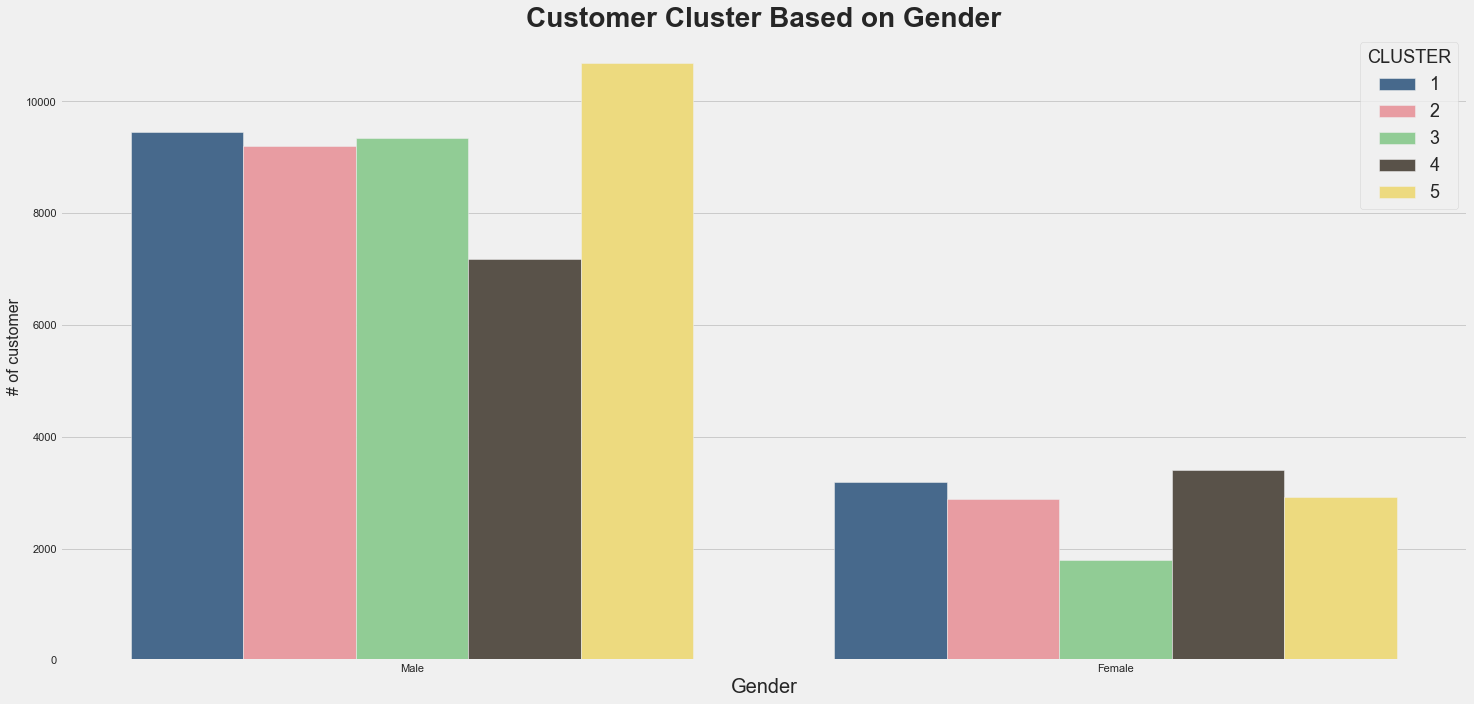

In [185]:
plt.figure(figsize = (20.7, 10))
# plot proportion    
sns.countplot(
    x = 'GENDER_x',
    hue = 'cluster',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    order = join_dataset['GENDER_x'].value_counts().index,
    data = join_dataset.replace(np.nan, 'Male')
)

L = plt.legend(fontsize = 18)
L.get_texts()[0].set_text('1')
L.get_texts()[1].set_text('2')
L.get_texts()[2].set_text('3')
L.get_texts()[3].set_text('4')
L.get_texts()[4].set_text('5')
L.set_title('CLUSTER', prop = {'size' : 18})

plt.xlabel('Gender', fontsize = 20)
plt.ylabel('# of customer', fontsize = 16)

plt.title('Customer Cluster Based on Gender', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight gender.png', bbox_inches = 'tight')

## Number of Customers in Cluster Group

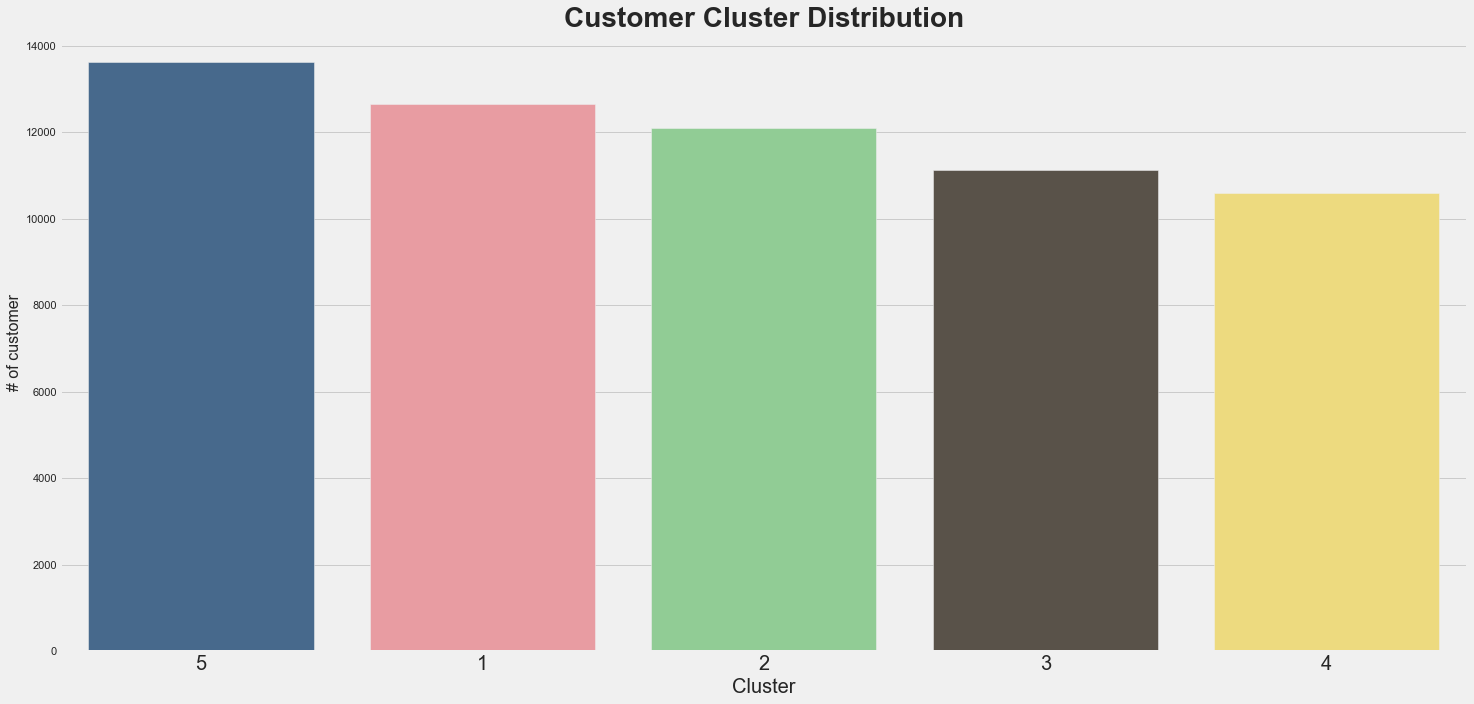

In [191]:
plt.figure(figsize = (20.7, 10))
    
sns.countplot(
    x = 'cluster',
    palette = ['#3c6997', '#f49097', '#87d68d', '#5c5346', '#ffe66d'],
    order = join_dataset['cluster'].value_counts().index,
    data = join_dataset
)

plt.xticks(np.arange(5), ('5', '1', '2', '3', '4'), fontsize = 20)

plt.xlabel('Cluster', fontsize = 20)
plt.ylabel('# of customer', fontsize = 16)

plt.title('Customer Cluster Distribution', fontweight = 'bold', fontsize = 28)

plt.tight_layout()

plt.savefig('fig/Insight/insight customer cluster.png', bbox_inches = 'tight')